<a href="https://colab.research.google.com/github/vhppacheco/ic-ita-finance-ia/blob/main/clustering/clustering_modeling_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Libs

In [584]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [585]:
!pip install -q yfinance
!pip install selenium
!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
!pip install sqldf
!pip install -q tsfeatures
!pip install umap-learn
!pip install Riskfolio-Lib
!pip install -U matplotlib

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:5 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Ign:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:15 http://ppa.launchpad.net/graph

In [586]:
import requests
import pandas as pd
from time import sleep
import yfinance as yf
from bs4 import BeautifulSoup
from selenium import webdriver
import json
import sys
import datetime

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labelencoder_X = LabelEncoder()
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 30,12
from pandas.plotting import register_matplotlib_converters

from matplotlib import pyplot

from sklearn.metrics import mean_squared_error
from math import sqrt

sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
wd = webdriver.Chrome('chromedriver',chrome_options=chrome_options)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: use options instead of chrome_options


# Concatenado

##Reading data

In [597]:
df_ibov = pd.read_excel('/content/drive/MyDrive/IC ITA/df_Ibov_Final.xlsx')
df_ibov['Indice'] = 'Ibov'

df_sp500 = pd.read_excel('/content/drive/MyDrive/IC ITA/df_SP500_Final.xlsx')
df_sp500['Indice'] = 'S&P500'

df_indicators = pd.concat([df_sp500,df_ibov])

##EDA

In [598]:
df_indicators.isnull().sum()

Data                                                                  0
 LiqCor  consolid:sim*                                                0
 LiqSec  consolid:sim*                                                0
 Exig / PL  consolid:sim*                                             0
 DivBr/Ebitda  de 3 meses  consolid:sim*                              0
 Margem Liquida  de 3 meses  consolid:sim*                            0
ROA de 3 meses                                                        0
ROE de 3 meses                                                        0
P/L de 3 meses ajust pela infl                                        0
Valor Mercado da empresa Em US Dollars em milhares                    0
 Patrim Liq  Em US Dollars  em milhares  consolid:sim*                0
Price/Book ratio                                                      0
EV Em US Dollars em milhares consolid:sim*                            0
EV/EBITDA emp Em US Dollars de 3 meses consolid:sim*            

In [599]:
#Cria as colunas de sharpe ratio e beta unindo o sp500 e ibov
df_indicators['Sharpe Ratio'] = df_indicators['Sharpe Ibov'].fillna(0) + df_indicators['Sharpe SP500'].fillna(0)
df_indicators['Beta'] = df_indicators['Beta Ibov'].fillna(0) + df_indicators['Beta sp500'].fillna(0)
df_indicators.drop(['Sharpe Ibov','Sharpe SP500','Beta Ibov','Beta sp500'],axis='columns',inplace=True)

In [600]:
df_indicators.isna().sum()

Data                                                              0
 LiqCor  consolid:sim*                                            0
 LiqSec  consolid:sim*                                            0
 Exig / PL  consolid:sim*                                         0
 DivBr/Ebitda  de 3 meses  consolid:sim*                          0
 Margem Liquida  de 3 meses  consolid:sim*                        0
ROA de 3 meses                                                    0
ROE de 3 meses                                                    0
P/L de 3 meses ajust pela infl                                    0
Valor Mercado da empresa Em US Dollars em milhares                0
 Patrim Liq  Em US Dollars  em milhares  consolid:sim*            0
Price/Book ratio                                                  0
EV Em US Dollars em milhares consolid:sim*                        0
EV/EBITDA emp Em US Dollars de 3 meses consolid:sim*              0
P/FCF Em US Dollars de 3 meses consolid:sim*    

In [601]:
#Cria a coluna Código ajustado, que tem o ".SA" no final do ticker das ações brasileiras
df_indicators['Código ajustado']=df_indicators['Código']
df_indicators.loc[df_indicators['Indice']=='Ibov','Código ajustado'] = df_indicators.loc[df_indicators['Indice']=='Ibov','Código ajustado']+str('.SA')

In [602]:
df_indicators.sort_values(by='Sharpe Ratio',ascending=False).head(10)

,Data,LiqCor consolid:sim*,LiqSec consolid:sim*,Exig / PL consolid:sim*,DivBr/Ebitda de 3 meses consolid:sim*,Margem Liquida de 3 meses consolid:sim*,ROA de 3 meses,ROE de 3 meses,P/L de 3 meses ajust pela infl,Valor Mercado da empresa Em US Dollars em milhares,...,Bollinger 90/2 Média Em moeda orig,Volatilidade base trimestral 3 meses Em moeda orig,VAR % base diária confiança: 95% 3 meses Em moeda orig,Max Drd (c/rec) ajust p/ prov 3 meses Em moeda orig,Data do Bal consolid:sim*,Código,Indice,Sharpe Ratio,Beta,Código ajustado
881,2T2020,0.969591,0.969591,-2143.867924,4408.500000,-63.422819,-2.907916,-72.721165,-13.235294,5.095251e+06,...,11.563151,59.391471,12.679423,-20.795107,2020-06-30,APA,S&P500,157.899168,2.212060,APA
1697,2T2020,1.171241,0.793256,474.113686,15.680451,1.231061,0.224238,1.287384,319.899453,4.463321e+06,...,10.289778,47.397036,10.079435,-14.585415,2020-06-30,VIIA3,Ibov,126.037491,1.530518,VIIA3.SA
2753,2T2020,3.224224,3.187735,280.367522,-131.806724,-79.066972,-1.626362,-6.186152,-32.048000,3.117348e+06,...,27.494833,69.298549,14.893212,-19.277108,2020-06-30,CZR,S&P500,117.537770,3.224298,CZR
253,2T2019,0.826152,1.627830,614.760245,8.758159,5.786735,0.389633,2.784939,86.624658,2.660698e+06,...,4.105840,42.520387,9.283152,-17.391304,2019-06-30,BPAN4,Ibov,87.108130,0.799509,BPAN4.SA
3713,2T2020,4.271905,4.271905,236.153193,6.455266,22.490478,5.472378,18.395574,141.640000,1.260716e+07,...,66.109167,36.099187,7.712768,-13.488263,2020-06-30,ETSY,S&P500,86.077443,0.900129,ETSY
233,2T2020,1.090801,0.781532,788.043293,14.454332,20.176641,0.437707,3.887032,68.123789,1.563549e+07,...,12.032654,37.416778,7.858583,-18.000000,2020-06-30,BPAC11,Ibov,51.532180,1.590610,BPAC11.SA
5047,4T2017,2.258499,1.380312,280.138099,-21.115152,-22.225619,-3.883962,-14.764419,-17.138365,1.311608e+07,...,25.702191,152.324218,34.873657,-11.719884,2017-12-31,HWM,S&P500,49.449637,4.794849,HWM
8010,3T2020,2.373019,2.373019,462.830110,38.969927,12.498894,0.953281,5.365353,78.172043,1.000566e+07,...,44.176222,44.085921,9.374779,-10.372924,2020-09-30,PENN,S&P500,48.197818,1.662363,PENN
1134,3T2017,1.105365,0.654432,590.098192,6.417938,3.237908,1.555100,10.731716,137.034134,4.427051e+06,...,1.515092,34.876538,7.258369,-7.959184,2017-09-30,MGLU3,Ibov,47.247596,1.256333,MGLU3.SA
8009,2T2020,1.989128,1.989128,851.657917,-171.530758,-70.180033,-1.497050,-14.246794,-18.071006,3.567015e+06,...,21.570056,60.429931,12.628828,-16.496507,2020-06-30,PENN,S&P500,43.609430,2.262890,PENN


In [603]:
df_indicators.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12936 entries, 0 to 1775
Data columns (total 27 columns):
 #   Column                                                          Non-Null Count  Dtype         
---  ------                                                          --------------  -----         
 0   Data                                                            12936 non-null  object        
 1    LiqCor  consolid:sim*                                          12936 non-null  float64       
 2    LiqSec  consolid:sim*                                          12936 non-null  float64       
 3    Exig / PL  consolid:sim*                                       12936 non-null  float64       
 4    DivBr/Ebitda  de 3 meses  consolid:sim*                        12936 non-null  float64       
 5    Margem Liquida  de 3 meses  consolid:sim*                      12936 non-null  float64       
 6   ROA de 3 meses                                                  12936 non-null  float64

In [604]:
#normaliza as colunas de formato float
columns = [' LiqCor  consolid:sim*', ' LiqSec  consolid:sim*',
       ' Exig / PL  consolid:sim*', ' DivBr/Ebitda  de 3 meses  consolid:sim*',
       ' Margem Liquida  de 3 meses  consolid:sim*', 'ROA de 3 meses',
       'ROE de 3 meses', 'P/L de 3 meses ajust pela infl',
       'Valor Mercado da empresa Em US Dollars em milhares',
       ' Patrim Liq  Em US Dollars  em milhares  consolid:sim*',
       'Price/Book ratio', 'EV Em US Dollars em milhares consolid:sim*',
       'EV/EBITDA emp Em US Dollars de 3 meses consolid:sim*',
       'P/FCF Em US Dollars de 3 meses consolid:sim*',
       'Media do fechamento em 1 trimestre Em US Dollars ajust p/ prov',
       'TIR média trimestral em 3 meses Em moeda orig',
       'Bollinger 90/2 Média Em moeda orig',
       'Volatilidade base trimestral 3 meses Em moeda orig',
       'VAR % base diária confiança: 95% 3 meses Em moeda orig',
       'Max Drd (c/rec) ajust p/ prov 3 meses Em moeda orig',
       'Sharpe Ratio', 'Beta']

for column in columns:
  #indicators_application[column] = indicators_application[column].loc[indicators_application[column].isnull()==False]
  #indicators_application = indicators_application[np.isfinite(indicators_application[column]) == True]
  df_indicators[column] = (df_indicators[column]-min(df_indicators[column].dropna())) /(max(df_indicators[column].dropna())-min(df_indicators[column].dropna()))

In [605]:
periodo = '4T2021'
best_10_sharpe = df_indicators.loc[df_indicators['Data'].astype(str) == periodo].sort_values(by='Sharpe Ratio',ascending=False).head(10)['Código ajustado']
df_indicators.loc[df_indicators['Data'].astype(str) == periodo].sort_values(by='Sharpe Ratio',ascending=False).head(10)

,Data,LiqCor consolid:sim*,LiqSec consolid:sim*,Exig / PL consolid:sim*,DivBr/Ebitda de 3 meses consolid:sim*,Margem Liquida de 3 meses consolid:sim*,ROA de 3 meses,ROE de 3 meses,P/L de 3 meses ajust pela infl,Valor Mercado da empresa Em US Dollars em milhares,...,Bollinger 90/2 Média Em moeda orig,Volatilidade base trimestral 3 meses Em moeda orig,VAR % base diária confiança: 95% 3 meses Em moeda orig,Max Drd (c/rec) ajust p/ prov 3 meses Em moeda orig,Data do Bal consolid:sim*,Código,Indice,Sharpe Ratio,Beta,Código ajustado
3167,4T2021,0.005816,0.004681,0.310483,0.288402,0.918283,0.536246,0.327556,0.032488,0.008569,...,0.010578,0.045307,0.041000,0.949153,2021-12-31,DRE,S&P500,0.120480,0.302646,DRE
1487,4T2021,0.011484,0.017970,0.311654,0.289028,0.917747,0.529116,0.328455,0.032349,0.006907,...,0.001397,0.307273,0.281714,0.655358,2021-12-31,SANB11,Ibov,0.119010,0.530994,SANB11.SA
791,4T2021,0.064319,0.056223,0.310486,0.288406,0.918078,0.574935,0.328812,0.032456,0.015150,...,0.021249,0.151534,0.144948,0.831061,2021-12-31,ANET,S&P500,0.118209,0.439363,ANET
1391,4T2021,0.005118,0.006056,0.310708,0.288908,0.917693,0.539308,0.328305,0.032390,0.000277,...,0.001959,0.086177,0.078419,0.919646,2021-12-31,QUAL3,Ibov,0.104410,0.263097,QUAL3.SA
8255,4T2021,0.008103,0.006348,0.310477,0.288970,0.919505,0.550202,0.328119,0.032395,0.042714,...,0.027417,0.053107,0.048062,0.942226,2021-12-31,PLD,S&P500,0.101887,0.320513,PLD
1175,4T2021,0.015358,0.012374,0.311277,0.288791,0.917590,0.557702,0.333970,0.032345,0.000889,...,0.000660,0.352811,0.328569,0.580767,2021-12-31,MRFG3,Ibov,0.096943,0.415707,MRFG3.SA
9599,4T2021,0.046883,0.043150,0.310491,0.288429,0.918001,0.595667,0.329607,0.032414,0.009138,...,0.025739,0.115078,0.106553,0.925599,2021-12-31,TER,S&P500,0.091730,0.470193,TER
1127,4T2021,0.024769,0.022586,0.310568,0.288631,0.917698,0.547858,0.328295,0.032367,0.001470,...,0.000000,0.282239,0.259923,0.418303,2021-12-31,LREN3,Ibov,0.091727,0.360955,LREN3.SA
1199,4T2021,0.034650,0.018657,0.310665,0.288961,0.917842,0.544466,0.328544,0.032342,0.000344,...,0.003120,0.080263,0.073121,0.904832,2021-12-31,MRVE3,Ibov,0.091317,0.296295,MRVE3.SA
3863,4T2021,0.025113,0.026031,0.310508,0.289440,0.918780,0.555392,0.329569,0.032404,0.010408,...,0.036633,0.066107,0.060074,0.929003,2021-12-31,EXR,S&P500,0.089186,0.338431,EXR


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


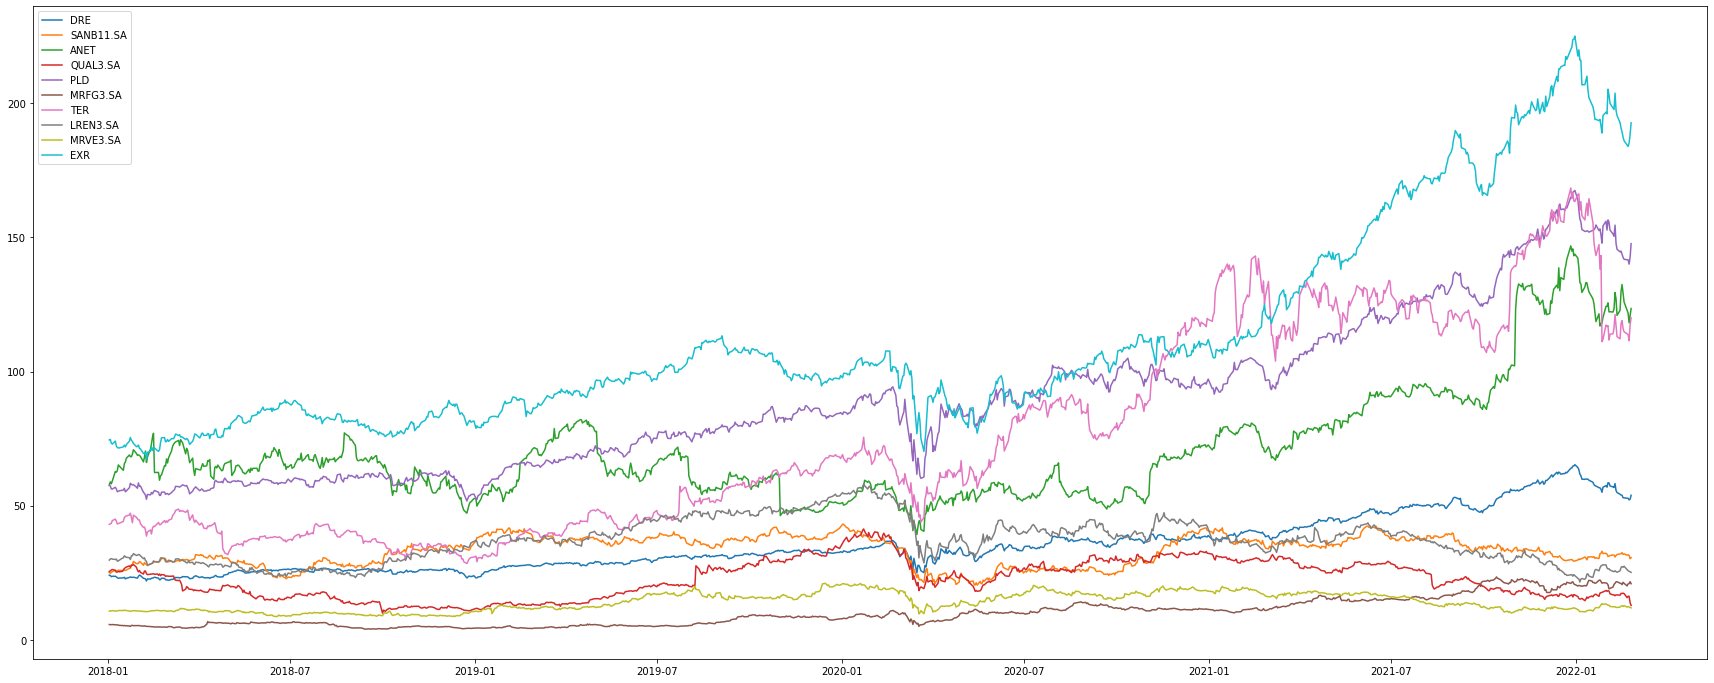

In [606]:
for i in range(0,len(best_10_sharpe)):
  plt.plot(pd.DataFrame(yf.download(best_10_sharpe.iloc[i], start = '2018-01-01', end = '2022-02-28')['Adj Close']),label=str(best_10_sharpe.iloc[i]))
  plt.legend()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


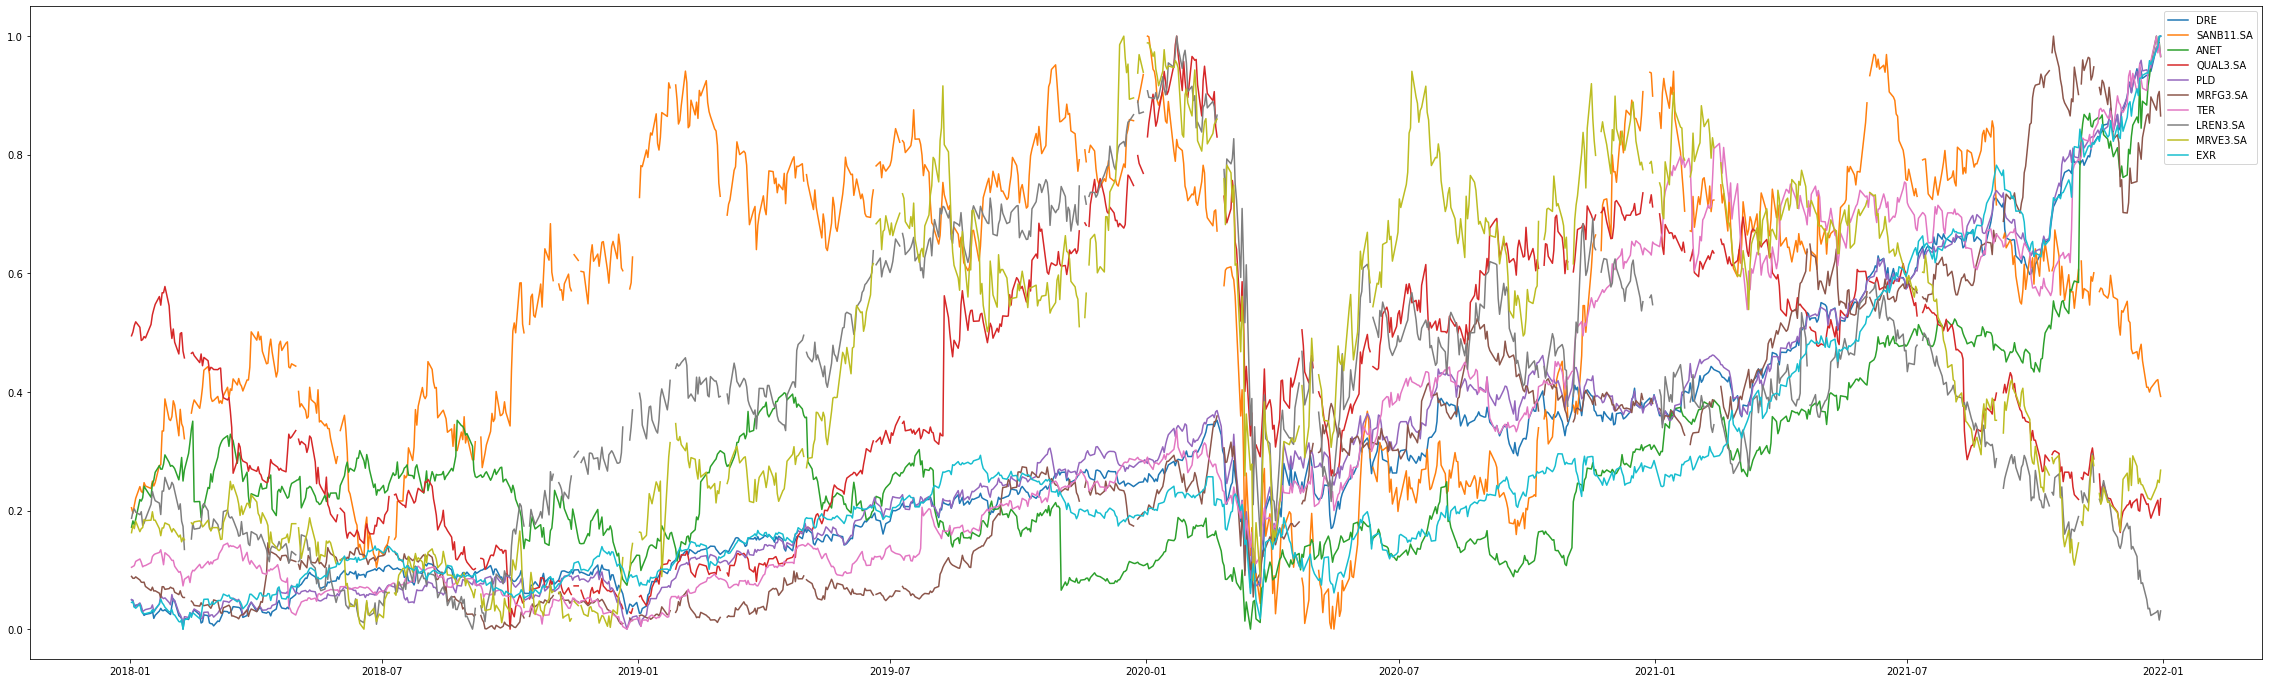

In [607]:
for i in range(0,len(best_10_sharpe)):
  if i == 0:
    best_10 = pd.DataFrame(yf.download(best_10_sharpe.iloc[i], start = '2018-01-01', end = '2021-12-31')['Adj Close']).rename(columns={'Adj Close':best_10_sharpe.iloc[i]})
  else:
    best_10[str(best_10_sharpe.iloc[i])] = pd.DataFrame(yf.download(best_10_sharpe.iloc[i], start = '2018-01-01', end = '2021-12-31')['Adj Close']).rename(columns={'Adj Close':best_10_sharpe.iloc[i]})

for column in best_10.columns:
  best_10[column] = (best_10[column]-min(best_10[column])) /(max(best_10[column])-min(best_10[column]))

rcParams['figure.figsize'] = 40,12
for i in range(0,len(best_10.columns)):
  plt.plot(best_10.iloc[:,i],label=best_10.columns[i])
  plt.legend()

[*********************100%***********************]  1 of 1 completed


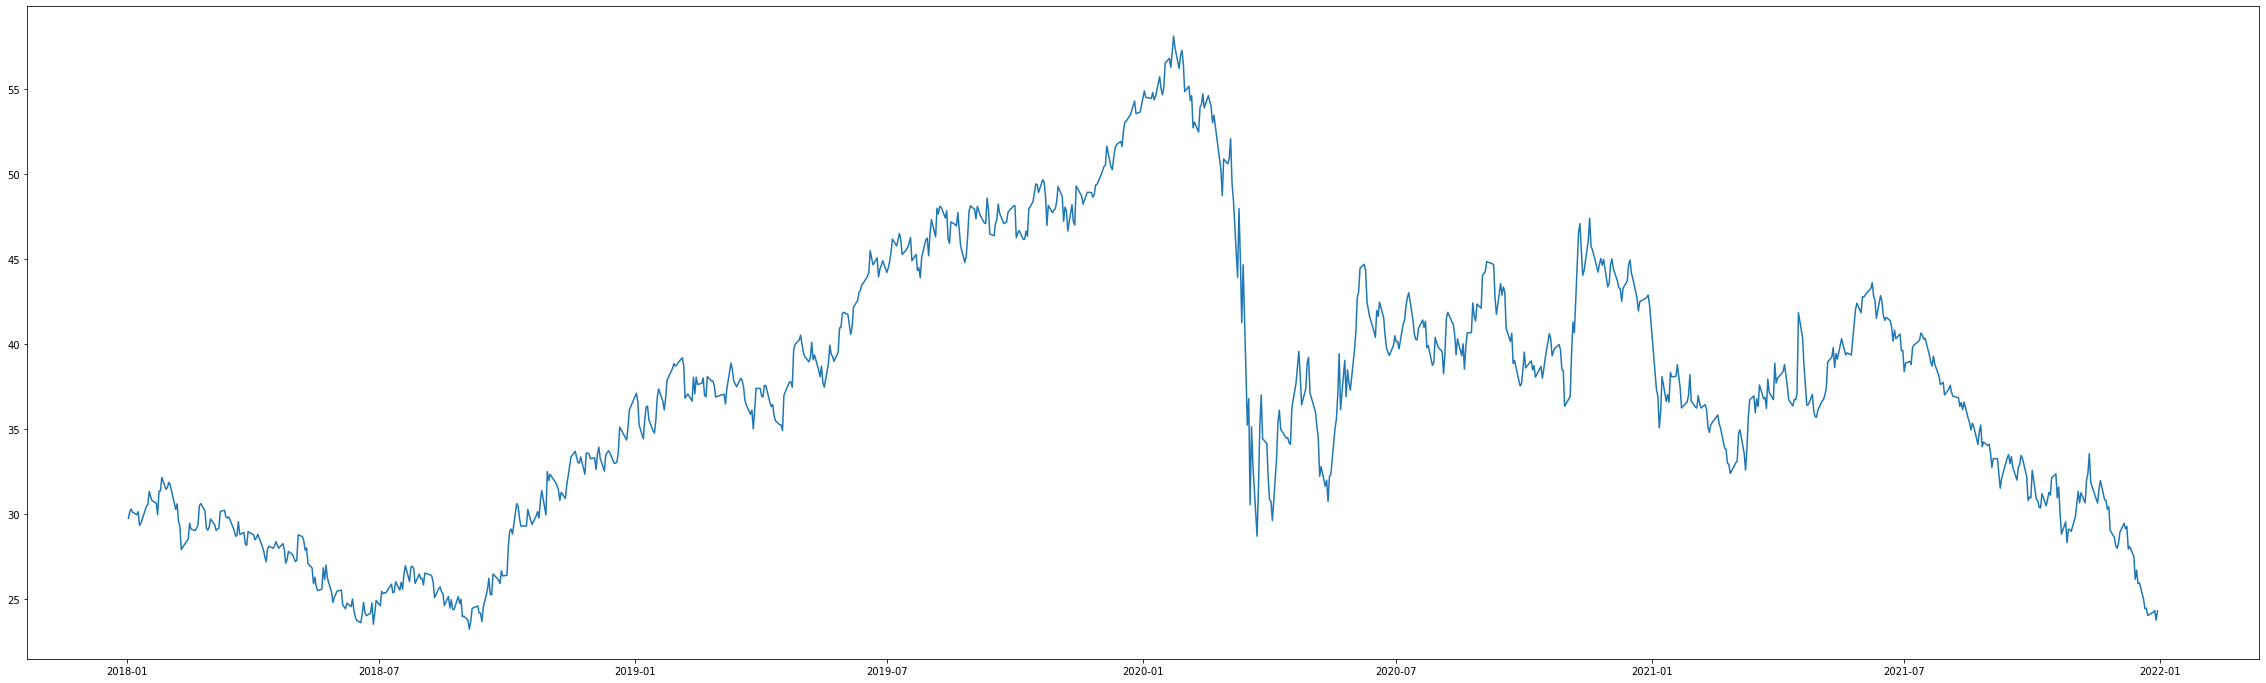

In [608]:
plt.plot(pd.DataFrame(yf.download('LREN3.SA', start = '2018-01-01', end = '2021-12-31')['Adj Close']))

##Models Applications

##UMAP testing

In [609]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns 
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,10

In [610]:
import umap

In [611]:
indicators_application = df_indicators.loc[(df_indicators['Data'].astype(str)=='4T2021')].drop(['Data','Código', ' Data do Bal  consolid:sim*','Indice','Código ajustado'],axis='columns').replace('-',0).astype(float)
indicators_application = indicators_application.fillna(0)

In [612]:
indicators_application = indicators_application.fillna(0)

In [613]:
indicators_data = indicators_application[columns].values
scaled_indicators_data = StandardScaler().fit_transform(indicators_data)

In [614]:
indicators_data.shape

(539, 22)

In [615]:
reducer = umap.UMAP()

In [616]:
embedding = reducer.fit_transform(indicators_data)
embedding.shape 

(539, 2)

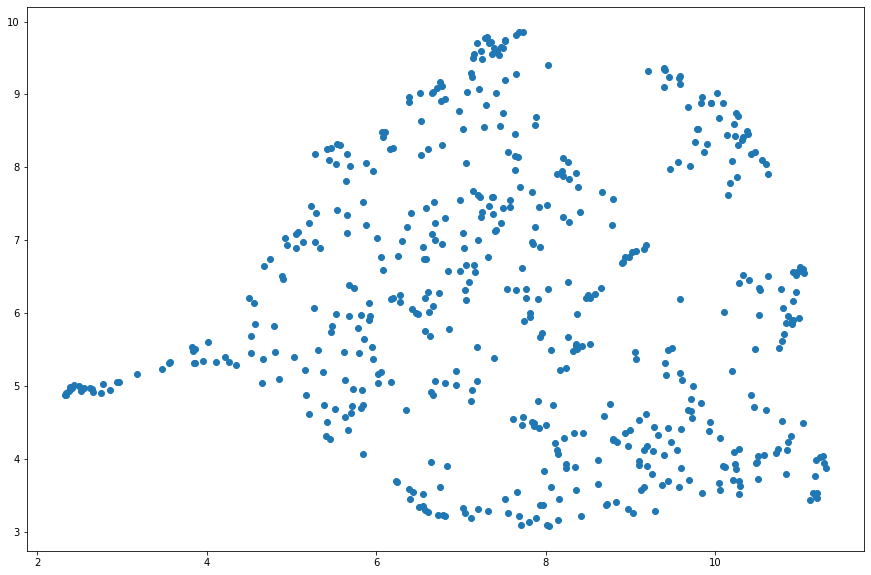

In [617]:
plt.scatter(embedding[:,0], embedding[:,1])

Text(0.5, 1.0, 'UMAP projection of the S&P500 and Ibov Index')

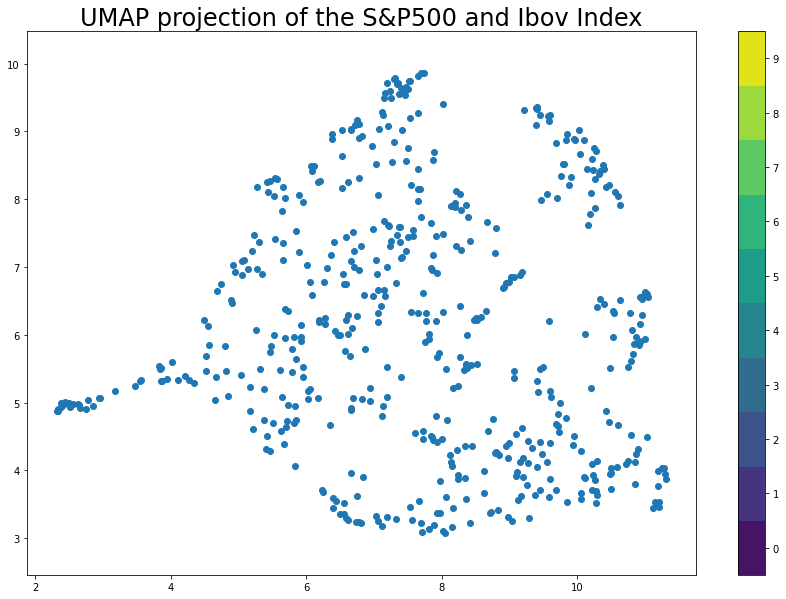

In [618]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    #c=indicators_data
    )
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of the S&P500 and Ibov Index', fontsize=24)

In [619]:
data = indicators_data 

In [620]:
def draw_umap(n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(data);
    fig = plt.figure()
    if n_components == 1:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], 
                   range(len(u)), 
                   #c=data
                   )
    if n_components == 2:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], 
                   u[:,1], 
                   #c=data
                   )
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(u[:,0], 
                   u[:,1], 
                   u[:,2], 
                   #c=data
                   )
    plt.title(title, fontsize=18)

In [621]:
#for n in (2, 5, 10, 20, 50, 100, 200,300,400,500):
#    draw_umap(n_neighbors=n, title='n_neighbors = {}'.format(n))

In [622]:
#for d in (0.0, 0.1, 0.25, 0.5, 0.8, 0.99):
#    draw_umap(min_dist=d, title='min_dist = {}'.format(d))

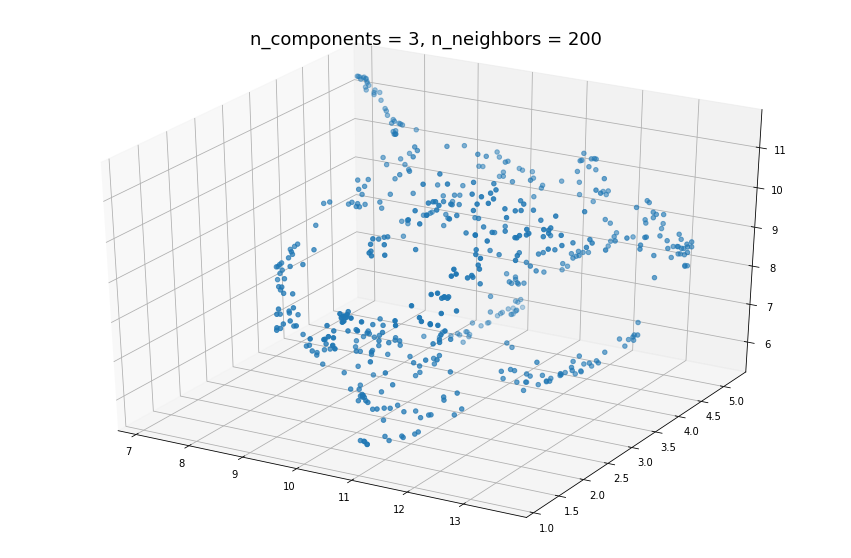

In [623]:
draw_umap(n_components=3,n_neighbors=15, title='n_components = 3, n_neighbors = 200')

##K-Means application for UMAP output

In [624]:
kmeans_input = pd.DataFrame(embedding)
kmeans_input.rename(columns={0:'x',1:'y'},inplace=True)

In [625]:
columns = ['x','y']
#Normalização dos dados
for column in columns:
  kmeans_input[column] = (kmeans_input[column]-min(kmeans_input[column].dropna()))/(max(kmeans_input[column].dropna())-min(kmeans_input[column].dropna()))

In [626]:
X = kmeans_input.iloc[:,[0,1]].values

In [627]:
import pandas as pd
import matplotlib as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labelencoder_X = LabelEncoder()
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,10
from pandas.plotting import register_matplotlib_converters

from matplotlib import pyplot

from sklearn.metrics import mean_squared_error
from math import sqrt

In [628]:
WCSS = []

In [629]:
for i in range (1,11):
  kmeans = KMeans(n_clusters=i,random_state=0)
  kmeans.fit(X)
  WCSS.append(kmeans.inertia_)

Text(0, 0.5, 'wcss')

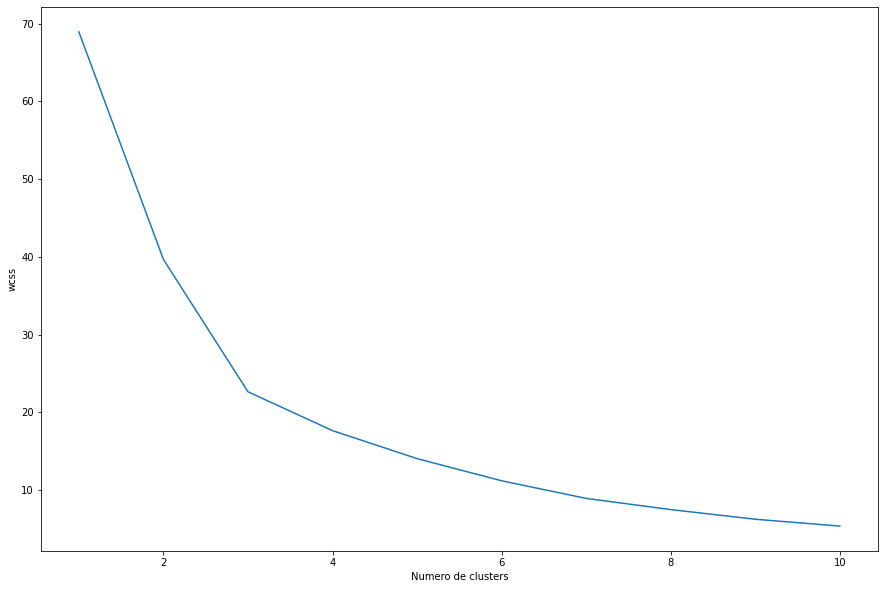

In [630]:
plt.plot(range(1,11),WCSS)
plt.xlabel('Numero de clusters')
plt.ylabel('wcss')

In [631]:
kmeans = KMeans(n_clusters=3, random_state=0)
previsoes = kmeans.fit_predict(X)

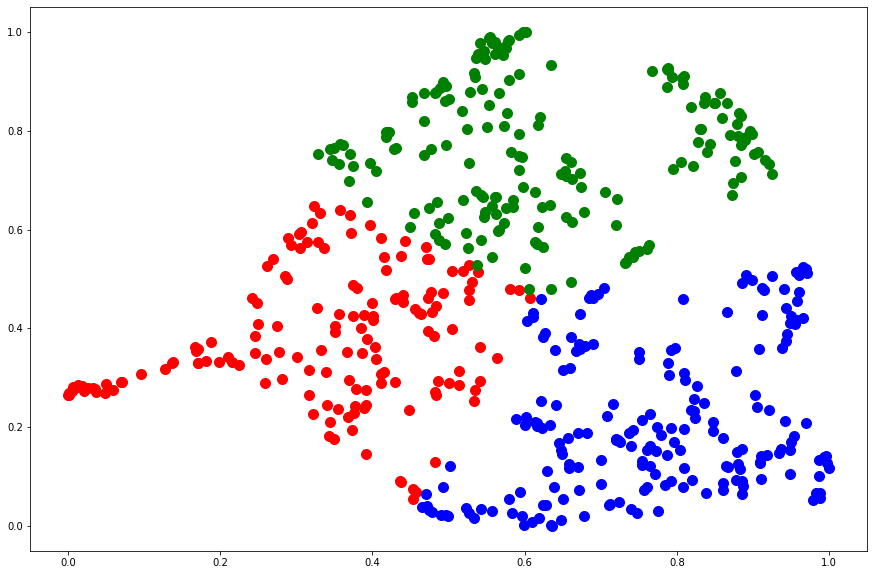

In [632]:
plt.scatter(X[previsoes == 0,0], X[previsoes == 0,1],s=100, c='red', label = 'Cluster 1')
plt.scatter(X[previsoes == 1,0], X[previsoes == 1,1],s=100, c='green', label = 'Cluster 2')
plt.scatter(X[previsoes == 2,0], X[previsoes == 2,1],s=100, c='blue', label = 'Cluster 3')
plt.scatter(X[previsoes == 3,0], X[previsoes == 3,1],s=100, c='yellow', label = 'Cluster 4')
plt.scatter(X[previsoes == 4,0], X[previsoes == 4,1],s=100, c='orange', label = 'Cluster 5')

In [633]:
kmeans_output = pd.DataFrame(np.column_stack((kmeans_input, previsoes)))

In [634]:
kmeans_output

,0,1,2
0,0.902228,0.264938,2.0
1,0.436890,0.089029,0.0
2,0.439783,0.454042,0.0
3,0.763278,0.568361,1.0
4,0.662759,0.702398,1.0
...,...,...,...
534,0.328784,0.752536,1.0
535,0.496466,0.023044,2.0
536,0.171304,0.330485,0.0
537,0.095147,0.307776,0.0


In [635]:
kmeans_output = kmeans_output.rename(columns={0:'x',1:'y',2:'Cluster'})

In [636]:
#preenchendo a coluna de clusters no dataframe principal
indicators_application['Cluster UMAP K-Means'] = ''
for i in range(0,len(indicators_application)):
  cluster = int(kmeans_output['Cluster'].iloc[i])
  indicators_application['Cluster UMAP K-Means'].iloc[i] = int(cluster)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [637]:
kmeans_output.groupby('Cluster',dropna=False).count()

,x,y
Cluster,,
0.0,155,155
1.0,182,182
2.0,202,202


##UMAP n-neighbors x WCSS K-means

In [638]:
def optimal_number_of_clusters(wcss):
    x1, y1 = 2, wcss[0]
    x2, y2 = 20, wcss[len(wcss)-1]

    distances = []
    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]
        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
    
    return distances.index(max(distances)) + 2

In [639]:
#função que plota o gráfico do WCSS pra cada n_neighbors do UMAP e adiciona os resultados numa matriz
def umap_kmeans(n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(data);

    #k-means
    kmeans_input = pd.DataFrame(u)
    kmeans_input.rename(columns={0:'x',1:'y'},inplace=True)

    columns = ['x','y']
    for column in columns:
      kmeans_input[column] = (kmeans_input[column]-min(kmeans_input[column].dropna()))/(max(kmeans_input[column].dropna())-min(kmeans_input[column].dropna()))

    X = kmeans_input.iloc[:,[0,1]].values

    WCSS = []
    for i in range (1,11):
      kmeans = KMeans(n_clusters=i,random_state=0)
      kmeans.fit(X)
      WCSS.append(kmeans.inertia_)

    rel_umap_kmeans[0].append(n_neighbors)
    rel_umap_kmeans[1].append(optimal_number_of_clusters(WCSS))

    plt.plot(range(1,11),WCSS)
    plt.xlabel('Numero de clusters')
    plt.ylabel('wcss')

In [640]:
rel_umap_kmeans = [[],[]]

#for n in range(2,200+1):
#    umap_kmeans(n_neighbors=n, title='n_neighbors = {}'.format(n))

In [641]:
#test = pd.DataFrame(rel_umap_kmeans).T
#test.rename(columns={0:'n_neighbors',1:'n_clusters'},inplace=True)

In [642]:
#plt.plot(test['n_neighbors'],test['n_clusters'])
#plt.xlabel('n_neighbors')
#plt.ylabel('n_clusters')

##K-Means application for the same features used in UMAP

In [643]:
indicators_data.shape

(539, 22)

In [644]:
X = indicators_data#.iloc[:,[0,13]].values

In [645]:
X

array([[0.03191799, 0.02538281, 0.31054655, ..., 0.9860361 , 0.0286086 ,
        0.35548741],
       [0.01179027, 0.01127408, 0.30933001, ..., 0.76668083, 0.01997574,
        0.46376017],
       [0.01638119, 0.00352471, 0.31075716, ..., 0.81127262, 0.04158899,
        0.36752196],
       ...,
       [0.01218247, 0.01267671, 0.31050972, ..., 0.68481885, 0.03561662,
        0.35984155],
       [0.02865266, 0.0170084 , 0.31051589, ..., 0.54782158, 0.01965955,
        0.35403255],
       [0.02224398, 0.02316535, 0.3106641 , ..., 1.        , 0.01356663,
        0.4033829 ]])

In [646]:
WCSS = []

In [647]:
for i in range (1,11):
  kmeans = KMeans(n_clusters=i,random_state=0)
  kmeans.fit(X)
  WCSS.append(kmeans.inertia_)

Text(0, 0.5, 'wcss')

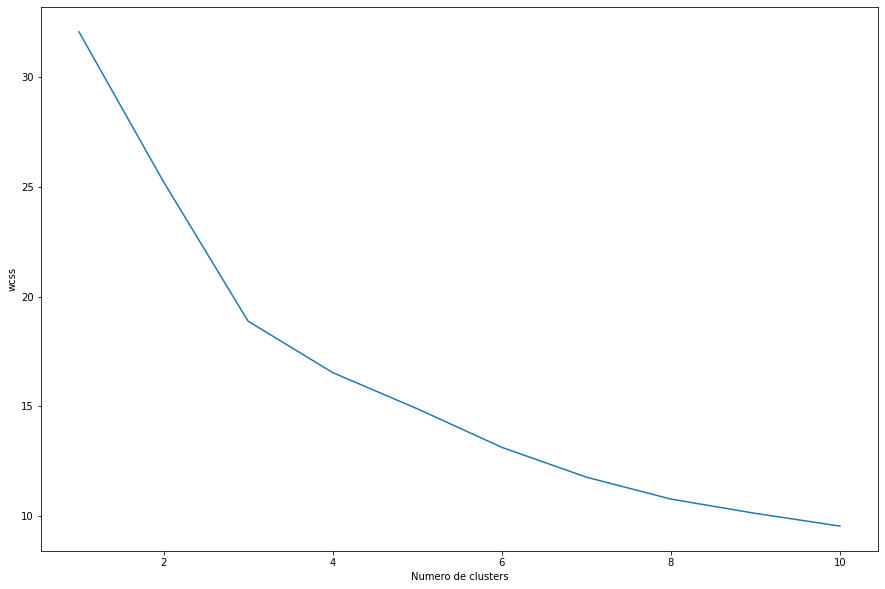

In [648]:
plt.plot(range(1,11),WCSS)
plt.xlabel('Numero de clusters')
plt.ylabel('wcss')

In [649]:
kmeans = KMeans(n_clusters=4, random_state=0)
previsoes = kmeans.fit_predict(X)

In [650]:
kmeans_output = pd.DataFrame(np.column_stack((kmeans_input, previsoes)))

In [651]:
kmeans_output = kmeans_output.rename(columns={0:'x',1:'y',2:'Cluster'})

In [652]:
indicators_application['Cluster k-means'] = ''
for i in range(0,len(indicators_application)):
  cluster = int(kmeans_output['Cluster'].iloc[i])
  indicators_application['Cluster k-means'].iloc[i] = int(cluster)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [653]:
kmeans_output.groupby('Cluster',dropna=False).count()

,x,y
Cluster,,
0.0,319,319
1.0,195,195
2.0,19,19
3.0,6,6


In [654]:
indicators_application.columns

Index([' LiqCor  consolid:sim*', ' LiqSec  consolid:sim*',
       ' Exig / PL  consolid:sim*', ' DivBr/Ebitda  de 3 meses  consolid:sim*',
       ' Margem Liquida  de 3 meses  consolid:sim*', 'ROA de 3 meses',
       'ROE de 3 meses', 'P/L de 3 meses ajust pela infl',
       'Valor Mercado da empresa Em US Dollars em milhares',
       ' Patrim Liq  Em US Dollars  em milhares  consolid:sim*',
       'Price/Book ratio', 'EV Em US Dollars em milhares consolid:sim*',
       'EV/EBITDA emp Em US Dollars de 3 meses consolid:sim*',
       'P/FCF Em US Dollars de 3 meses consolid:sim*',
       'Media do fechamento em 1 trimestre Em US Dollars ajust p/ prov',
       'TIR média trimestral em 3 meses Em moeda orig',
       'Bollinger 90/2 Média Em moeda orig',
       'Volatilidade base trimestral 3 meses Em moeda orig',
       'VAR % base diária confiança: 95% 3 meses Em moeda orig',
       'Max Drd (c/rec) ajust p/ prov 3 meses Em moeda orig', 'Sharpe Ratio',
       'Beta', 'Cluster UMAP K-Means

##PAM

In [655]:
!pip install scikit-learn-extra

In [656]:
# — — — — — — -Importing Packages — — — — — — — — — — — -
from sklearn_extra.cluster import KMedoids

In [657]:
X = kmeans_input.iloc[:,[0,1]].values

In [658]:
kmedoids = KMedoids(n_clusters=3, random_state=0).fit(X)

In [659]:
import random

In [660]:
kmeans_input

,x,y
0,0.902228,0.264938
1,0.436890,0.089029
2,0.439783,0.454042
3,0.763278,0.568361
4,0.662759,0.702398
...,...,...
534,0.328784,0.752536
535,0.496466,0.023044
536,0.171304,0.330485
537,0.095147,0.307776


In [661]:
kmedoids.predict([X[random.randint(0, len(X))],
                  X[random.randint(0, len(X))],
                  X[random.randint(0, len(X))]])

array([2, 0, 2])

In [662]:
kmedoids.cluster_centers_

array([[0.6544626 , 0.7445779 ],
       [0.76519233, 0.16283455],
       [0.38542083, 0.4007638 ]], dtype=float32)

Text(0.5, 1.0, 'KMedoids clustering. Medoids are represented in cyan.')

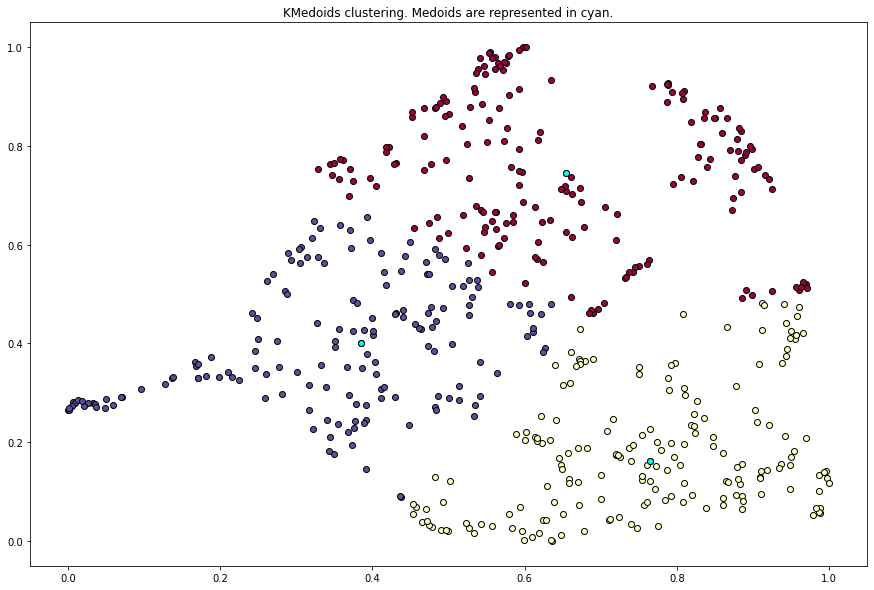

In [663]:
labels = kmedoids.labels_

unique_labels = set(labels)
colors = [
    plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))
]
for k, col in zip(unique_labels, colors):

    class_member_mask = labels == k

    xy = X[class_member_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.plot(
    kmedoids.cluster_centers_[:, 0],
    kmedoids.cluster_centers_[:, 1],
    "o",
    markerfacecolor="cyan",
    markeredgecolor="k",
    markersize=6,
)

plt.title("KMedoids clustering. Medoids are represented in cyan.")

In [664]:
indicators_application['Cluster PAM'] = ''
for i in range(0,len(indicators_application)):
  cluster = int(kmedoids.labels_[i])
  indicators_application['Cluster PAM'].iloc[i] = int(cluster)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


##Hierarquical

In [665]:
Y = kmeans_input
Y

,x,y
0,0.902228,0.264938
1,0.436890,0.089029
2,0.439783,0.454042
3,0.763278,0.568361
4,0.662759,0.702398
...,...,...
534,0.328784,0.752536
535,0.496466,0.023044
536,0.171304,0.330485
537,0.095147,0.307776


<Figure size 21600x21600 with 0 Axes>

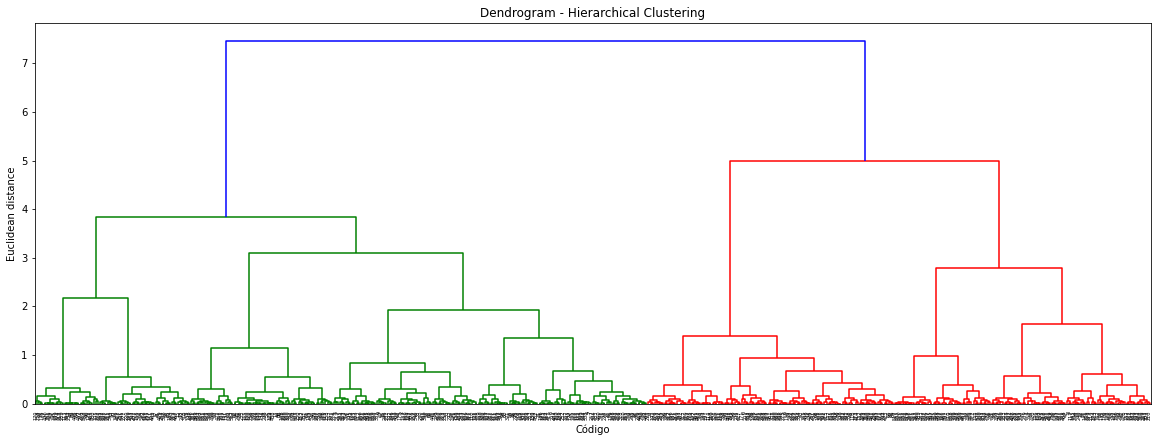

<Figure size 21600x21600 with 0 Axes>

In [666]:
import scipy.cluster.hierarchy as sc

# Plot dendrogram
plt.figure(figsize=(20, 7))  
plt.title("Dendrograms")  

# Create dendrogram
sc.dendrogram(sc.linkage(Y, method='ward'))

plt.title('Dendrogram - Hierarchical Clustering')
plt.xlabel('Código')
plt.ylabel('Euclidean distance')
plt.figure(figsize = (300, 300))

In [667]:
from sklearn.cluster import AgglomerativeClustering

In [668]:
cluster_hierarquical = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
hierarquical = cluster_hierarquical.fit(Y)

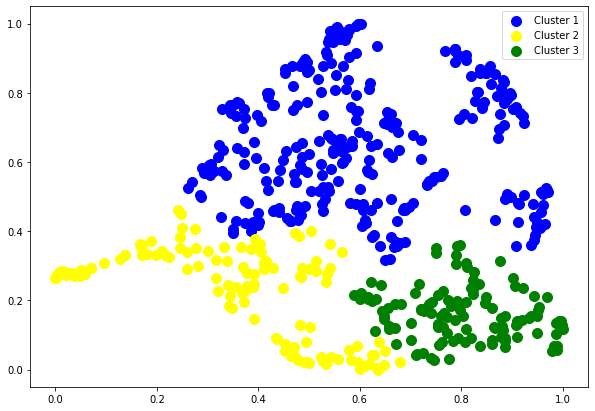

In [669]:
indicators = Y.values

plt.figure(figsize=(10, 7))
plt.scatter(indicators[hierarquical.labels_ == 0, 0], indicators[hierarquical.labels_ == 0, 1], s = 100, c = 'blue', label = 'Cluster 1')
plt.scatter(indicators[hierarquical.labels_ == 1, 0], indicators[hierarquical.labels_ == 1, 1], s = 100, c = 'yellow', label = 'Cluster 2')
plt.scatter(indicators[hierarquical.labels_ == 2, 0], indicators[hierarquical.labels_ == 2, 1], s = 100, c = 'green', label = 'Cluster 3')
plt.legend()
plt.show()

In [670]:
hierarquical_output = pd.DataFrame(np.column_stack((kmeans_input, hierarquical.labels_)))

In [671]:
hierarquical_output = hierarquical_output.rename(columns={0:'x',1:'y',2:'Cluster'})

In [672]:
indicators_application['Cluster Hierarquical'] = ''
for i in range(0,len(indicators_application)):
  cluster = int(hierarquical_output['Cluster'].iloc[i])
  indicators_application['Cluster Hierarquical'].iloc[i] = int(cluster)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


## Consolidação

In [673]:
df_indicators.columns

Index(['Data', ' LiqCor  consolid:sim*', ' LiqSec  consolid:sim*',
       ' Exig / PL  consolid:sim*', ' DivBr/Ebitda  de 3 meses  consolid:sim*',
       ' Margem Liquida  de 3 meses  consolid:sim*', 'ROA de 3 meses',
       'ROE de 3 meses', 'P/L de 3 meses ajust pela infl',
       'Valor Mercado da empresa Em US Dollars em milhares',
       ' Patrim Liq  Em US Dollars  em milhares  consolid:sim*',
       'Price/Book ratio', 'EV Em US Dollars em milhares consolid:sim*',
       'EV/EBITDA emp Em US Dollars de 3 meses consolid:sim*',
       'P/FCF Em US Dollars de 3 meses consolid:sim*',
       'Media do fechamento em 1 trimestre Em US Dollars ajust p/ prov',
       'TIR média trimestral em 3 meses Em moeda orig',
       'Bollinger 90/2 Média Em moeda orig',
       'Volatilidade base trimestral 3 meses Em moeda orig',
       'VAR % base diária confiança: 95% 3 meses Em moeda orig',
       'Max Drd (c/rec) ajust p/ prov 3 meses Em moeda orig',
       ' Data do Bal  consolid:sim*', 'Códig

In [674]:
len(indicators_application) - len(df_indicators)

-12397

In [675]:
df_indicators['Cluster UMAP K-Means'] = ''
df_indicators['Cluster k-means'] = ''
df_indicators['Cluster PAM'] = ''
df_indicators['Cluster Hierarquical'] = ''

In [676]:
df_indicators.loc[(df_indicators['Data'].astype(str)==periodo),'Cluster UMAP K-Means'] = indicators_application['Cluster UMAP K-Means'].astype(float)
df_indicators.loc[(df_indicators['Data'].astype(str)==periodo),'Cluster k-means'] = indicators_application['Cluster k-means'].astype(float)
df_indicators.loc[(df_indicators['Data'].astype(str)==periodo),'Cluster PAM'] = indicators_application['Cluster PAM'].astype(float)
df_indicators.loc[(df_indicators['Data'].astype(str)==periodo),'Cluster Hierarquical'] = indicators_application['Cluster Hierarquical'].astype(float)

In [677]:
df_indicators_dtref = df_indicators.loc[(df_indicators['Data'].astype(str)==periodo)]

In [678]:
df_indicators_dtref[['Cluster UMAP K-Means', 'Cluster k-means', 'Cluster PAM','Cluster Hierarquical']] = df_indicators_dtref[['Cluster UMAP K-Means', 'Cluster k-means', 'Cluster PAM','Cluster Hierarquical']].astype(float)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


# IBOVESPA

##Models Applications

##UMAP testing

In [78]:
ibov_application = df_ibov.loc[(df_ibov[' Data do Bal  consolid:sim*'].astype(str)>='2021-10-01') & (df_ibov[' Data do Bal  consolid:sim*'].astype(str)<='2021-12-31')].drop(['Data','Código', ' Data do Bal  consolid:sim*','Indice'],axis='columns').replace('-',0).astype(float)
ibov_application = ibov_application.fillna(0)

In [79]:
ibov_application.columns

Index([' LiqCor  consolid:sim*', ' LiqSec  consolid:sim*',
       ' Exig / PL  consolid:sim*', ' DivBr/Ebitda  de 3 meses  consolid:sim*',
       ' Margem Liquida  de 3 meses  consolid:sim*', 'ROA de 3 meses',
       'ROE de 3 meses', 'P/L de 3 meses ajust pela infl',
       'Valor Mercado da empresa Em US Dollars em milhares',
       ' Patrim Liq  Em US Dollars  em milhares  consolid:sim*',
       'Price/Book ratio', 'EV Em US Dollars em milhares consolid:sim*',
       'EV/EBITDA emp Em US Dollars de 3 meses consolid:sim*',
       'P/FCF Em US Dollars de 3 meses consolid:sim*',
       'Media do fechamento em 1 trimestre Em US Dollars ajust p/ prov',
       'Beta Ibov', 'TIR média trimestral em 3 meses Em moeda orig',
       'Bollinger 90/2 Média Em moeda orig',
       'Volatilidade base trimestral 3 meses Em moeda orig', 'Sharpe Ibov',
       'VAR % base diária confiança: 95% 3 meses Em moeda orig',
       'Max Drd (c/rec) ajust p/ prov 3 meses Em moeda orig'],
      dtype='object')

In [80]:
columns = [#'Fechamento ajust p/ prov Em moeda orig',
       #' Ativo Tot  ajust por infl  em milhares  consolid:sim*',
      ' LiqCor  consolid:sim*', ' LiqSec  consolid:sim*',
       ' Exig / PL  consolid:sim*', ' DivBr/Ebitda  de 3 meses  consolid:sim*',
       ' Margem Liquida  de 3 meses  consolid:sim*', 'ROA de 3 meses',
       'ROE de 3 meses', 'P/L de 3 meses ajust pela infl',
       'Valor Mercado da empresa Em US Dollars em milhares',
       ' Patrim Liq  Em US Dollars  em milhares  consolid:sim*',
       'Price/Book ratio', 'EV Em US Dollars em milhares consolid:sim*',
       'EV/EBITDA emp Em US Dollars de 3 meses consolid:sim*',
       'P/FCF Em US Dollars de 3 meses consolid:sim*',
       'Media do fechamento em 1 trimestre Em US Dollars ajust p/ prov',
       'Beta Ibov', 'TIR média trimestral em 3 meses Em moeda orig',
       'Bollinger 90/2 Média Em moeda orig',
       'Volatilidade base trimestral 3 meses Em moeda orig', 'Sharpe Ibov',
       'VAR % base diária confiança: 95% 3 meses Em moeda orig',
       'Max Drd (c/rec) ajust p/ prov 3 meses Em moeda orig']

for column in columns:
  ibov_application[column] = (ibov_application[column]-min(ibov_application[column].dropna())) /(max(ibov_application[column].dropna())-min(ibov_application[column].dropna()))

In [81]:
#ibov_application = ibov_application.fillna(0)

In [82]:
ibov_data = ibov_application[columns].values
scaled_ibov_data_data = StandardScaler().fit_transform(ibov_data)

In [83]:
ibov_data.shape

(74, 22)

In [84]:
reducer = umap.UMAP()

In [85]:
embedding_ibov = reducer.fit_transform(ibov_data)
embedding_ibov.shape 

(74, 2)

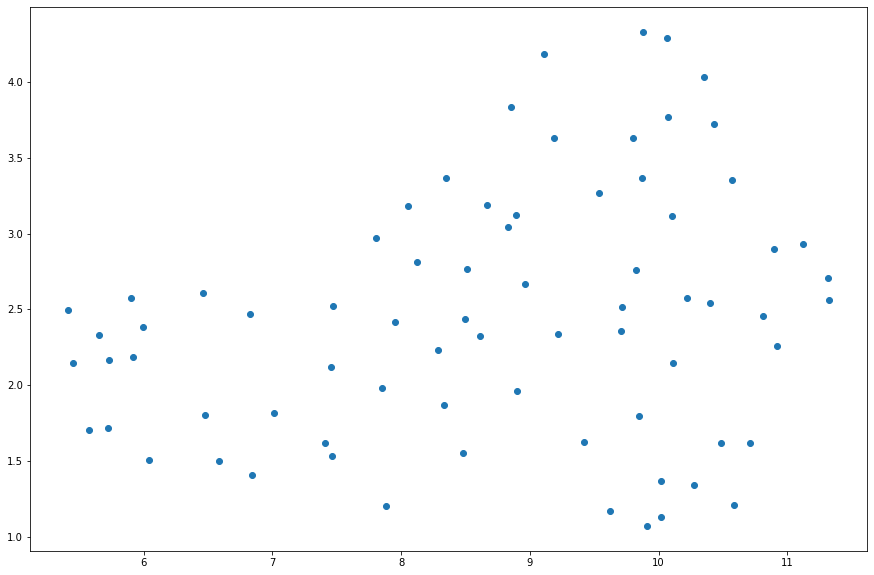

In [86]:
plt.scatter(embedding_ibov[:,0], embedding_ibov[:,1])

Text(0.5, 1.0, 'UMAP projection of the S&P500 and Ibov Index')

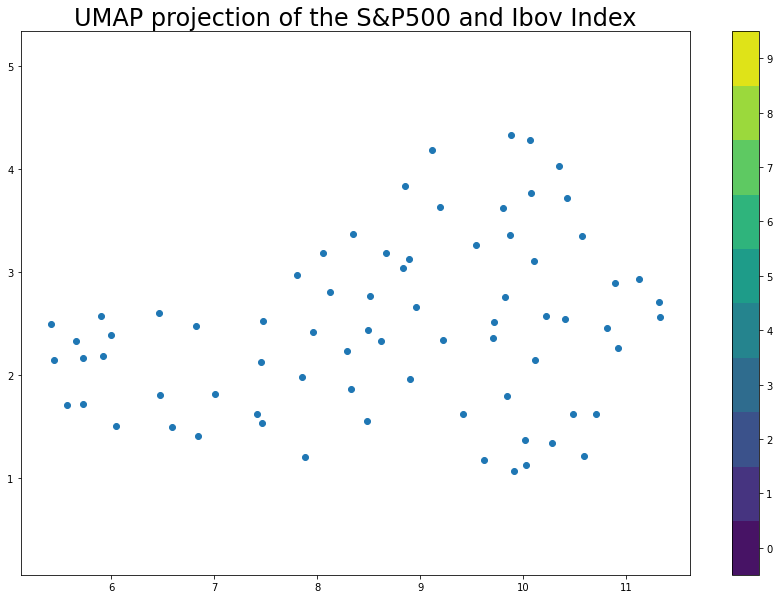

In [87]:
plt.scatter(
    embedding_ibov[:, 0],
    embedding_ibov[:, 1],
    #c=indicators_data
    )
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of the S&P500 and Ibov Index', fontsize=24)

In [88]:
data = ibov_data

In [89]:
def draw_umap(n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(data);
    fig = plt.figure()
    if n_components == 1:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], 
                   range(len(u)), 
                   #c=data
                   )
    if n_components == 2:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], 
                   u[:,1], 
                   #c=data
                   )
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(u[:,0], 
                   u[:,1], 
                   u[:,2], 
                   #c=data
                   )
    plt.title(title, fontsize=18)

In [90]:
#for n in (2, 5, 10, 20, 50, 100, 200):
#    draw_umap(n_neighbors=n, title='n_neighbors = {}'.format(n))

In [91]:
#for d in (0.0, 0.1, 0.25, 0.5, 0.8, 0.99):
#    draw_umap(min_dist=d, title='min_dist = {}'.format(d))

/usr/local/lib/python3.7/dist-packages/umap/umap_.py:2345: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  "n_neighbors is larger than the dataset size; truncating to "


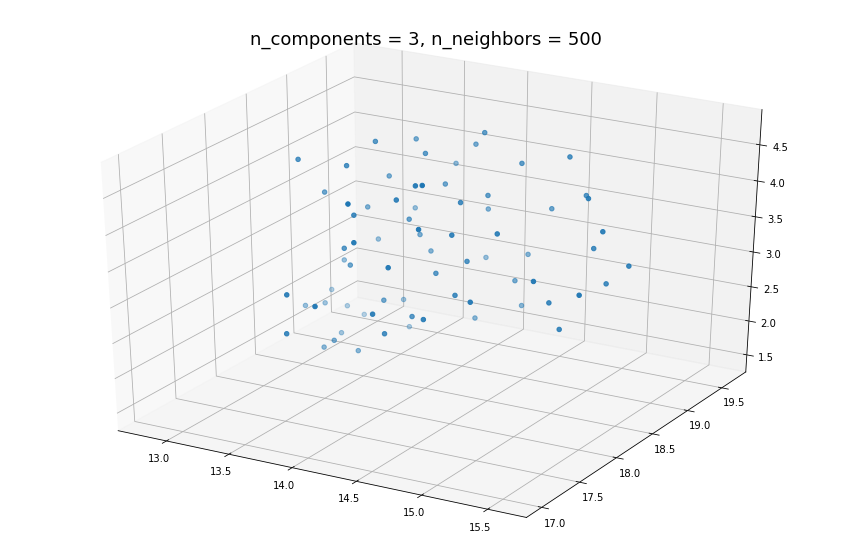

In [92]:
draw_umap(n_components=3,n_neighbors=500, title='n_components = 3, n_neighbors = 500')

##K-Means application for UMAP output

In [93]:
kmeans_input_ibov = pd.DataFrame(embedding_ibov)
kmeans_input_ibov.rename(columns={0:'x',1:'y'},inplace=True)

In [94]:
columns = ['x','y']
#Normalização dos dados
for column in columns:
  kmeans_input_ibov[column] = (kmeans_input_ibov[column]-min(kmeans_input_ibov[column].dropna()))/(max(kmeans_input_ibov[column].dropna())-min(kmeans_input_ibov[column].dropna()))

In [95]:
X = kmeans_input_ibov.iloc[:,[0,1]].values

In [96]:
import pandas as pd
import matplotlib as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labelencoder_X = LabelEncoder()
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,10
from pandas.plotting import register_matplotlib_converters

from matplotlib import pyplot

from sklearn.metrics import mean_squared_error
from math import sqrt

In [97]:
WCSS = []

In [98]:
for i in range (1,11):
  kmeans_ibov = KMeans(n_clusters=i,random_state=0)
  kmeans_ibov.fit(X)
  WCSS.append(kmeans_ibov.inertia_)

Text(0, 0.5, 'wcss')

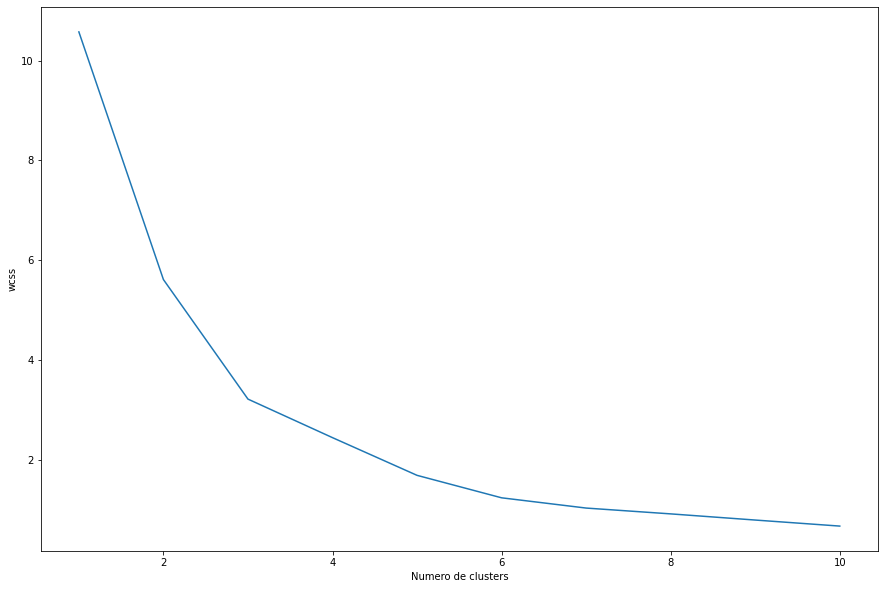

In [99]:
plt.plot(range(1,11),WCSS)
plt.xlabel('Numero de clusters')
plt.ylabel('wcss')

In [100]:
kmeans_ibov = KMeans(n_clusters=4, random_state=0)
previsoes = kmeans_ibov.fit_predict(X)

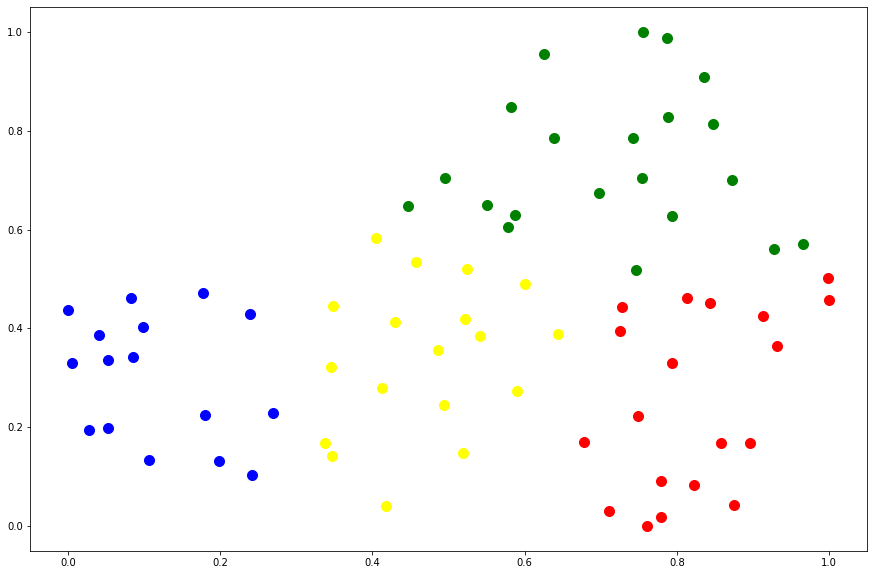

In [101]:
plt.scatter(X[previsoes == 0,0], X[previsoes == 0,1],s=100, c='red', label = 'Cluster 1')
plt.scatter(X[previsoes == 1,0], X[previsoes == 1,1],s=100, c='green', label = 'Cluster 2')
plt.scatter(X[previsoes == 2,0], X[previsoes == 2,1],s=100, c='blue', label = 'Cluster 3')
plt.scatter(X[previsoes == 3,0], X[previsoes == 3,1],s=100, c='yellow', label = 'Cluster 4')
#plt.scatter(X[previsoes == 4,0], X[previsoes == 4,1],s=100, c='yellow', label = 'Cluster 5')

In [102]:
kmeans_output_ibov = pd.DataFrame(np.column_stack((kmeans_input_ibov, previsoes)))

In [103]:
kmeans_output_ibov

,0,1,2
0,0.337893,0.168539,3.0
1,0.779520,0.018089,0.0
2,0.746264,0.517635,1.0
3,0.404782,0.583678,3.0
4,0.625347,0.955393,1.0
...,...,...,...
69,0.346253,0.141141,3.0
70,0.447161,0.648254,1.0
71,0.412275,0.278823,3.0
72,0.778797,0.091324,0.0


In [104]:
kmeans_output_ibov = kmeans_output_ibov.rename(columns={0:'x',1:'y',2:'Cluster'})

In [105]:
#preenchendo a coluna de clusters no dataframe principal
ibov_application['Cluster UMAP K-Means'] = ''
for i in range(0,len(ibov_application)):
  cluster = int(kmeans_output_ibov['Cluster'].iloc[i])
  ibov_application['Cluster UMAP K-Means'].iloc[i] = int(cluster)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [106]:
kmeans_output_ibov.groupby('Cluster',dropna=False).count()

,x,y
Cluster,,
0.0,19,19
1.0,21,21
2.0,16,16
3.0,18,18


##K-Means application for the same features used in UMAP

In [107]:
ibov_data.shape

(74, 22)

In [108]:
X = ibov_data#.iloc[:,[0,13]].values

In [109]:
import pandas as pd
import matplotlib as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labelencoder_X = LabelEncoder()
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 30,12
from pandas.plotting import register_matplotlib_converters

from matplotlib import pyplot

from sklearn.metrics import mean_squared_error
from math import sqrt

In [110]:
X

array([[0.13304838, 0.08685906, 0.0744061 , ..., 0.14300646, 0.22502275,
        0.46125575],
       [0.0901082 , 0.0525395 , 0.09566559, ..., 0.19214098, 0.04472861,
        0.86323112],
       [0.24801683, 0.1821197 , 0.11101708, ..., 0.38541314, 0.0094243 ,
        0.96808828],
       ...,
       [0.12310547, 0.12184361, 0.07448601, ..., 0.26044116, 0.13964141,
        0.68481885],
       [0.31324857, 0.17168401, 0.0762712 , ..., 0.11892886, 0.22887149,
        0.54782158],
       [0.23926248, 0.24252581, 0.1191595 , ..., 0.06489501, 0.11061895,
        1.        ]])

In [111]:
WCSS = []

In [112]:
for i in range (1,11):
  kmeans_ibov = KMeans(n_clusters=i,random_state=0)
  kmeans_ibov.fit(X)
  WCSS.append(kmeans_ibov.inertia_)

Text(0, 0.5, 'wcss')

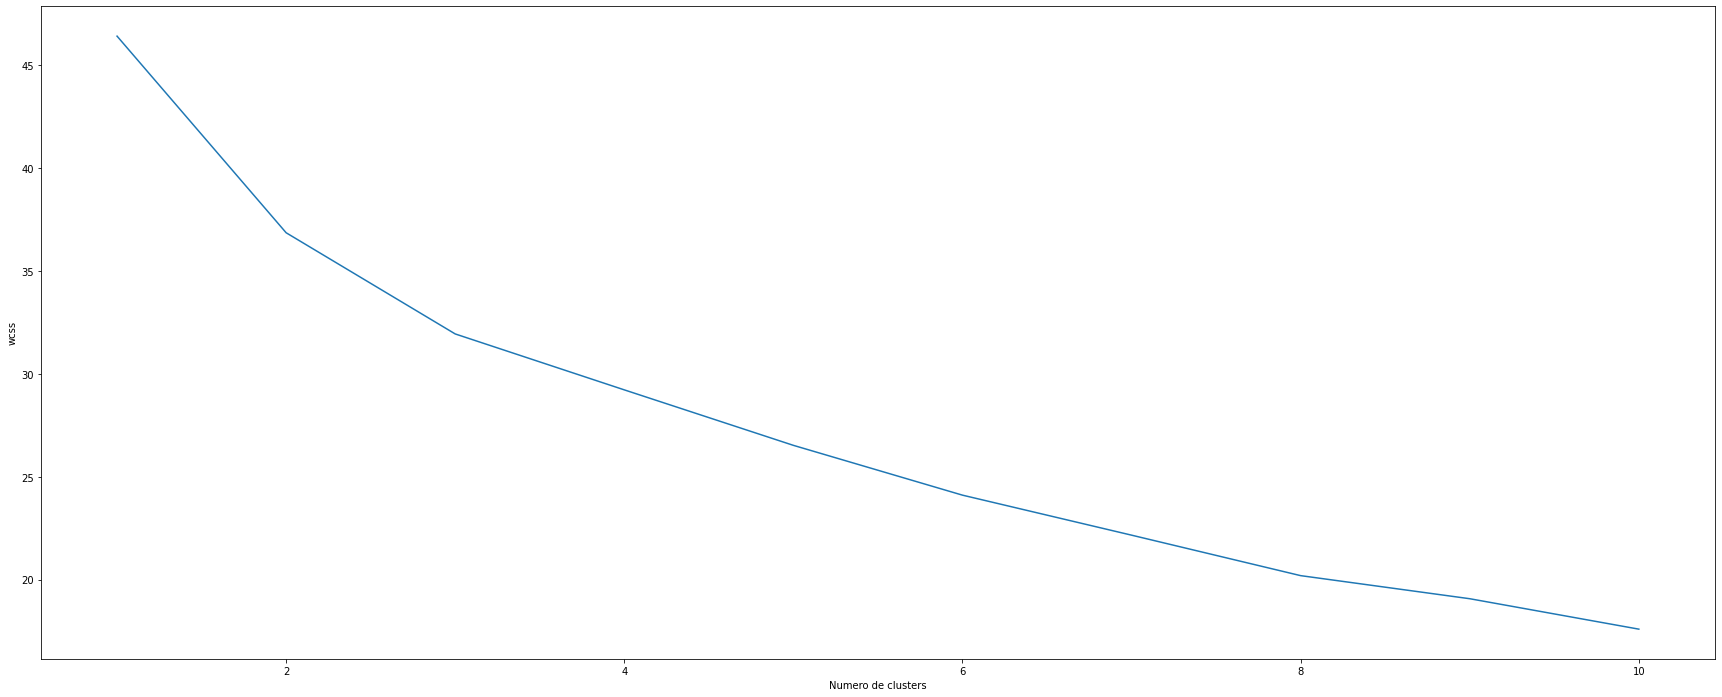

In [113]:
plt.plot(range(1,11),WCSS)
plt.xlabel('Numero de clusters')
plt.ylabel('wcss')

In [114]:
kmeans_ibov = KMeans(n_clusters=3, random_state=0)
previsoes = kmeans_ibov.fit_predict(X)

In [115]:
kmeans_output_ibov = pd.DataFrame(np.column_stack((kmeans_input_ibov, previsoes)))

In [116]:
kmeans_output_ibov = kmeans_output_ibov.rename(columns={0:'x',1:'y',2:'Cluster'})

In [117]:
ibov_application['Cluster k-means'] = ''
for i in range(0,len(ibov_application)):
  cluster = int(kmeans_output_ibov['Cluster'].iloc[i])
  ibov_application['Cluster k-means'].iloc[i] = int(cluster)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [118]:
kmeans_output_ibov.groupby('Cluster',dropna=False).count()

,x,y
Cluster,,
0.0,16,16
1.0,55,55
2.0,3,3


In [119]:
ibov_application

,LiqCor consolid:sim*,LiqSec consolid:sim*,Exig / PL consolid:sim*,DivBr/Ebitda de 3 meses consolid:sim*,Margem Liquida de 3 meses consolid:sim*,ROA de 3 meses,ROE de 3 meses,P/L de 3 meses ajust pela infl,Valor Mercado da empresa Em US Dollars em milhares,Patrim Liq Em US Dollars em milhares consolid:sim*,...,Media do fechamento em 1 trimestre Em US Dollars ajust p/ prov,Beta Ibov,TIR média trimestral em 3 meses Em moeda orig,Bollinger 90/2 Média Em moeda orig,Volatilidade base trimestral 3 meses Em moeda orig,Sharpe Ibov,VAR % base diária confiança: 95% 3 meses Em moeda orig,Max Drd (c/rec) ajust p/ prov 3 meses Em moeda orig,Cluster UMAP K-Means,Cluster k-means
23,0.133048,0.086859,0.074406,0.945109,0.383090,0.378334,0.552997,0.211568,0.624252,0.253920,...,0.159636,0.203309,0.224976,0.166221,0.279204,0.143006,0.225023,0.461256,3,1
47,0.090108,0.052539,0.095666,0.945389,0.440867,0.396558,0.607664,0.214209,0.046608,0.059869,...,0.238917,0.234287,0.335663,0.232293,0.054352,0.192141,0.044729,0.863231,0,1
71,0.248017,0.182120,0.111017,0.958428,0.343682,0.351019,0.535347,0.206873,0.069552,0.090515,...,0.167989,0.313574,0.434038,0.262149,0.010564,0.385413,0.009424,0.968088,1,1
95,0.245324,0.248562,0.096515,0.954197,0.477451,0.367681,0.558226,0.208776,0.170394,0.106424,...,0.176455,0.485639,0.000000,0.217214,0.579786,0.124738,0.448031,0.872806,3,1
119,0.087261,1.000000,0.447153,0.944590,0.370824,0.337435,0.547581,0.185579,0.209144,0.399255,...,0.251027,0.206593,0.143214,0.252750,0.186527,0.100795,0.145656,0.916762,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1679,0.217631,0.170197,0.102565,0.946956,0.473923,0.437222,0.695303,0.184165,0.972676,0.522688,...,0.040402,0.030567,0.903800,0.032558,0.182682,0.163713,0.145153,0.691520,3,2
1703,0.132119,0.068317,0.221691,0.961645,0.326665,0.333680,0.502615,0.322687,0.017747,0.065357,...,0.229562,0.546367,0.113644,0.236718,0.191280,0.096554,0.149078,0.867911,1,1
1727,0.123105,0.121844,0.074486,0.948361,0.402805,0.370980,0.543976,0.193260,0.205235,0.222783,...,0.092611,0.399096,0.430003,0.091466,0.175729,0.260441,0.139641,0.684819,3,1
1751,0.313249,0.171684,0.076271,0.946335,0.371732,0.395909,0.577523,0.257171,0.354260,0.084868,...,0.155039,0.385061,0.142980,0.150097,0.292462,0.118929,0.228871,0.547822,0,1


##PAM

In [120]:
!pip install scikit-learn-extra

In [121]:
# — — — — — — -Importing Packages — — — — — — — — — — — -
from sklearn_extra.cluster import KMedoids

In [122]:
PAM_input_ibov = pd.DataFrame(embedding_ibov)
PAM_input_ibov.rename(columns={0:'x',1:'y'},inplace=True)

In [123]:
columns = ['x','y']
#Normalização dos dados
for column in columns:
  PAM_input_ibov[column] = (PAM_input_ibov[column]-min(PAM_input_ibov[column].dropna()))/(max(PAM_input_ibov[column].dropna())-min(PAM_input_ibov[column].dropna()))

In [124]:
X = PAM_input_ibov.iloc[:,[0,1]].values

In [125]:
kmedoids = KMedoids(n_clusters=4, random_state=0).fit(X)

In [126]:
import random

In [127]:
X[random.randint(0, len(kmeans_input_ibov.iloc[:,[0,1]].values))]

array([0.3478382 , 0.44539002], dtype=float32)

In [128]:
kmedoids.predict([X[random.randint(0, len(X))],
                  X[random.randint(0, len(X))],
                  X[random.randint(0, len(X))],
                  X[random.randint(0, len(X))]])

array([1, 0, 0, 2])

In [129]:
kmedoids.cluster_centers_

array([[0.69794875, 0.673698  ],
       [0.08507518, 0.34303993],
       [0.41227496, 0.27882308],
       [0.7942626 , 0.33043596]], dtype=float32)

In [130]:
kmedoids.inertia_

12.78305

Text(0.5, 1.0, 'KMedoids clustering. Medoids are represented in cyan.')

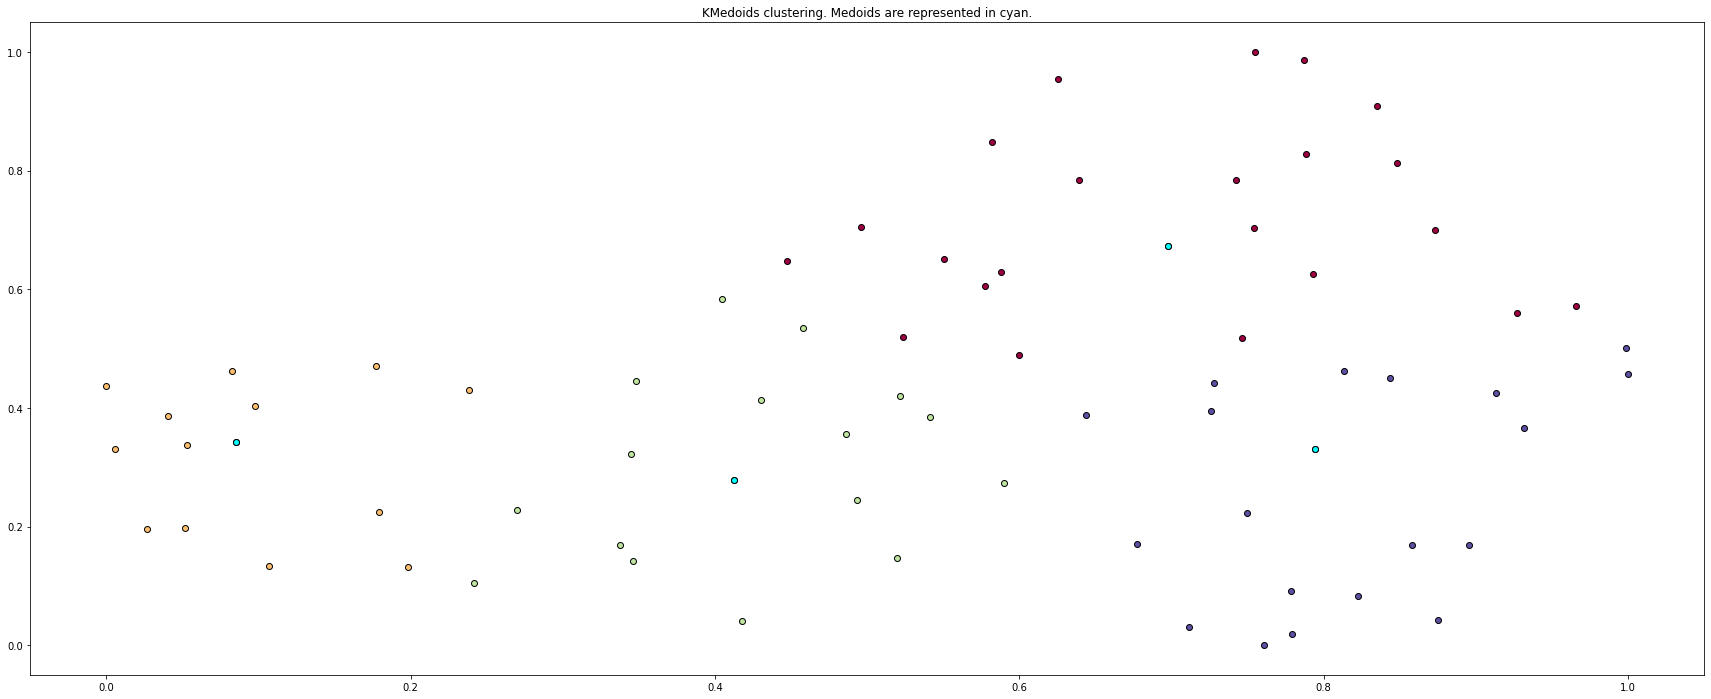

In [131]:
labels = kmedoids.labels_

unique_labels = set(labels)
colors = [
    plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))
]
for k, col in zip(unique_labels, colors):

    class_member_mask = labels == k

    xy = X[class_member_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.plot(
    kmedoids.cluster_centers_[:, 0],
    kmedoids.cluster_centers_[:, 1],
    "o",
    markerfacecolor="cyan",
    markeredgecolor="k",
    markersize=6,
)

plt.title("KMedoids clustering. Medoids are represented in cyan.")

In [132]:
kmedoids.cluster_centers_

array([[0.69794875, 0.673698  ],
       [0.08507518, 0.34303993],
       [0.41227496, 0.27882308],
       [0.7942626 , 0.33043596]], dtype=float32)

In [133]:
kmedoids.labels_

array([2, 3, 0, 2, 0, 2, 1, 3, 3, 0, 2, 3, 0, 0, 3, 1, 0, 1, 0, 3, 3, 2,
       3, 3, 1, 2, 3, 2, 0, 2, 0, 0, 2, 3, 0, 1, 1, 1, 2, 0, 0, 3, 2, 2,
       0, 3, 1, 3, 1, 3, 0, 0, 1, 2, 1, 2, 3, 3, 0, 0, 3, 1, 2, 0, 3, 0,
       0, 1, 1, 2, 0, 2, 3, 0])

In [134]:
ibov_application['Cluster PAM'] = ''
for i in range(0,len(ibov_application)):
  cluster = int(kmedoids.labels_[i])
  ibov_application['Cluster PAM'].iloc[i] = int(cluster)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


## Consolidação

In [135]:
ibov_application.columns

Index([' LiqCor  consolid:sim*', ' LiqSec  consolid:sim*',
       ' Exig / PL  consolid:sim*', ' DivBr/Ebitda  de 3 meses  consolid:sim*',
       ' Margem Liquida  de 3 meses  consolid:sim*', 'ROA de 3 meses',
       'ROE de 3 meses', 'P/L de 3 meses ajust pela infl',
       'Valor Mercado da empresa Em US Dollars em milhares',
       ' Patrim Liq  Em US Dollars  em milhares  consolid:sim*',
       'Price/Book ratio', 'EV Em US Dollars em milhares consolid:sim*',
       'EV/EBITDA emp Em US Dollars de 3 meses consolid:sim*',
       'P/FCF Em US Dollars de 3 meses consolid:sim*',
       'Media do fechamento em 1 trimestre Em US Dollars ajust p/ prov',
       'Beta Ibov', 'TIR média trimestral em 3 meses Em moeda orig',
       'Bollinger 90/2 Média Em moeda orig',
       'Volatilidade base trimestral 3 meses Em moeda orig', 'Sharpe Ibov',
       'VAR % base diária confiança: 95% 3 meses Em moeda orig',
       'Max Drd (c/rec) ajust p/ prov 3 meses Em moeda orig',
       'Cluster UMAP K-M

In [136]:
len(ibov_application) - len(df_ibov)

-1702

In [137]:
df_ibov['Cluster UMAP K-Means'] = ''
df_ibov['Cluster k-means'] = ''
df_ibov['Cluster PAM'] = ''

In [138]:
df_ibov.loc[(df_ibov[' Data do Bal  consolid:sim*'].astype(str)>='2021-10-01') & (df_ibov[' Data do Bal  consolid:sim*'].astype(str)<='2021-12-31'),'Cluster UMAP K-Means'] = ibov_application['Cluster UMAP K-Means'].astype(float)
df_ibov.loc[(df_ibov[' Data do Bal  consolid:sim*'].astype(str)>='2021-10-01') & (df_ibov[' Data do Bal  consolid:sim*'].astype(str)<='2021-12-31'),'Cluster k-means'] = ibov_application['Cluster k-means'].astype(float)
df_ibov.loc[(df_ibov[' Data do Bal  consolid:sim*'].astype(str)>='2021-10-01') & (df_ibov[' Data do Bal  consolid:sim*'].astype(str)<='2021-12-31'),'Cluster PAM'] = ibov_application['Cluster PAM'].astype(float)

In [139]:
ibov_dtref = df_ibov.loc[(df_ibov[' Data do Bal  consolid:sim*'].astype(str)>='2021-10-01') & (df_ibov[' Data do Bal  consolid:sim*'].astype(str)<='2021-12-31')]

In [140]:
ibov_dtref[['Cluster UMAP K-Means', 'Cluster k-means', 'Cluster PAM']] = ibov_dtref[['Cluster UMAP K-Means', 'Cluster k-means', 'Cluster PAM']].astype(float)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [141]:
ibov_dtref.loc[(ibov_dtref[' Data do Bal  consolid:sim*'].astype(str)>='2021-12-01') & (ibov_dtref[' Data do Bal  consolid:sim*'].astype(str)<='2021-12-31')][' Data do Bal  consolid:sim*'].drop_duplicates().reset_index().sort_values(by=' Data do Bal  consolid:sim*')

,index,Data do Bal consolid:sim*
0,23,2021-12-31


In [142]:
ibov_dtref.loc[(ibov_dtref[' Data do Bal  consolid:sim*'].astype(str)>='2021-10-01') & (ibov_dtref[' Data do Bal  consolid:sim*'].astype(str)<='2021-12-31')]['Código'].drop_duplicates().reset_index().sort_values(by='Código')

,index,Código
0,23,ABEV3
1,47,ALPA4
2,71,AMER3
3,95,B3SA3
4,119,BBAS3
...,...,...
69,1679,VALE3
70,1703,VIIA3
71,1727,VIVT3
72,1751,WEGE3


# S&P500

##Models Applications

##UMAP testing

In [143]:
df_sp500 = pd.read_excel('/content/drive/MyDrive/IC ITA/df_SP500_Final.xlsx')
df_sp500['Indice'] = 'S&P500'

In [144]:
sp500_application = df_sp500.loc[(df_sp500[' Data do Bal  consolid:sim*'].astype(str)>='2021-10-01') & (df_sp500[' Data do Bal  consolid:sim*'].astype(str)<='2021-12-31')].drop(['Data','Código', ' Data do Bal  consolid:sim*','Indice'],axis='columns').replace('-',0).astype(float)
sp500_application = sp500_application.fillna(0)

In [145]:
df_sp500.loc[(df_sp500[' Data do Bal  consolid:sim*'].astype(str)>='2021-10-01') & (df_sp500[' Data do Bal  consolid:sim*'].astype(str)<='2021-12-31')].drop(['Data','Código', ' Data do Bal  consolid:sim*','Indice'],axis='columns').replace('-',0).astype(float)

,LiqCor consolid:sim*,LiqSec consolid:sim*,Exig / PL consolid:sim*,DivBr/Ebitda de 3 meses consolid:sim*,Margem Liquida de 3 meses consolid:sim*,ROA de 3 meses,ROE de 3 meses,P/L de 3 meses ajust pela infl,Valor Mercado da empresa Em US Dollars em milhares,Patrim Liq Em US Dollars em milhares consolid:sim*,...,EV/EBITDA emp Em US Dollars de 3 meses consolid:sim*,P/FCF Em US Dollars de 3 meses consolid:sim*,Media do fechamento em 1 trimestre Em US Dollars ajust p/ prov,Beta sp500,TIR média trimestral em 3 meses Em moeda orig,Bollinger 90/2 Média Em moeda orig,Volatilidade base trimestral 3 meses Em moeda orig,Sharpe SP500,VAR % base diária confiança: 95% 3 meses Em moeda orig,Max Drd (c/rec) ajust p/ prov 3 meses Em moeda orig
23,2.224239,1.738290,98.645389,5.697286,26.626506,4.128912,8.201893,109.988037,4.821443e+07,5389000.0,...,103.065610,123.369730,162.549318,0.919580,3.182733,158.663155,9.812865,0.714812,2.015690,-0.724269
47,0.912133,0.817689,-1005.544959,25.435185,-9.886496,-1.402200,265.625000,-12.472222,1.162936e+07,-7340000.0,...,67.078754,13.066523,19.179063,1.574862,-12.293211,19.429000,23.622636,-0.682102,4.861684,-12.101617
70,1.211410,0.312039,289.804177,14.581537,6.744734,1.509419,5.412463,88.065337,1.495776e+07,3128291.0,...,60.776238,174.306773,205.420456,0.892116,3.570645,203.084219,10.894080,0.750326,2.251456,-7.493036
95,1.037812,0.997994,429.932436,2.779178,27.939812,9.084685,48.142690,84.298135,2.913284e+09,71932000.0,...,67.266469,93.387388,18.091171,1.216064,6.162620,21.155155,15.329335,0.980703,3.175393,0.000000
119,0.793544,0.704666,849.267945,10.872537,27.173183,2.760546,26.204975,59.911504,2.393710e+08,15408000.0,...,43.417697,63.202037,116.729468,0.407622,26.522526,114.241803,8.772711,9.091860,1.825712,-3.028264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11087,1.408633,0.718158,85.186004,20.418255,-4.116983,-0.357685,-0.662382,-317.600000,2.653967e+07,12660700.0,...,95.696052,123.256648,129.894725,1.043008,-12.847750,133.371366,14.637761,-1.337666,2.996340,-4.482505
11110,0.938333,0.665556,108.277480,4.028986,13.019768,3.073210,6.400804,168.135593,3.180838e+07,2984000.0,...,118.073824,567.895439,556.946094,1.346614,-3.894165,543.144111,10.745740,-0.645285,2.215024,-7.515052
11111,0.938333,0.665556,108.277480,4.028986,13.019768,3.073210,6.400804,168.135593,3.180838e+07,2984000.0,...,118.073824,567.895439,567.755312,1.434662,15.219256,567.863778,15.081051,2.582125,3.154033,-4.357202
11135,1.408633,0.718158,1148.827549,20.418255,-4.116983,0.228541,2.854080,46.441176,9.882232e+06,7463000.0,...,95.696052,123.256648,63.367824,1.203244,2.632861,61.692546,14.120122,0.292507,2.906561,-5.302003


In [146]:
df_sp500.dtypes

Data                                                                      object
 LiqCor  consolid:sim*                                                   float64
 LiqSec  consolid:sim*                                                   float64
 Exig / PL  consolid:sim*                                                float64
 DivBr/Ebitda  de 3 meses  consolid:sim*                                 float64
 Margem Liquida  de 3 meses  consolid:sim*                               float64
ROA de 3 meses                                                           float64
ROE de 3 meses                                                           float64
P/L de 3 meses ajust pela infl                                           float64
Valor Mercado da empresa Em US Dollars em milhares                       float64
 Patrim Liq  Em US Dollars  em milhares  consolid:sim*                   float64
Price/Book ratio                                                         float64
EV Em US Dollars em milhares

In [147]:
sp500_application.columns

Index([' LiqCor  consolid:sim*', ' LiqSec  consolid:sim*',
       ' Exig / PL  consolid:sim*', ' DivBr/Ebitda  de 3 meses  consolid:sim*',
       ' Margem Liquida  de 3 meses  consolid:sim*', 'ROA de 3 meses',
       'ROE de 3 meses', 'P/L de 3 meses ajust pela infl',
       'Valor Mercado da empresa Em US Dollars em milhares',
       ' Patrim Liq  Em US Dollars  em milhares  consolid:sim*',
       'Price/Book ratio', 'EV Em US Dollars em milhares consolid:sim*',
       'EV/EBITDA emp Em US Dollars de 3 meses consolid:sim*',
       'P/FCF Em US Dollars de 3 meses consolid:sim*',
       'Media do fechamento em 1 trimestre Em US Dollars ajust p/ prov',
       'Beta sp500', 'TIR média trimestral em 3 meses Em moeda orig',
       'Bollinger 90/2 Média Em moeda orig',
       'Volatilidade base trimestral 3 meses Em moeda orig', 'Sharpe SP500',
       'VAR % base diária confiança: 95% 3 meses Em moeda orig',
       'Max Drd (c/rec) ajust p/ prov 3 meses Em moeda orig'],
      dtype='object')

In [148]:
columns = [' LiqCor  consolid:sim*', ' LiqSec  consolid:sim*',
       ' Exig / PL  consolid:sim*', ' DivBr/Ebitda  de 3 meses  consolid:sim*',
       ' Margem Liquida  de 3 meses  consolid:sim*', 'ROA de 3 meses',
       'ROE de 3 meses', 'P/L de 3 meses ajust pela infl',
       'Valor Mercado da empresa Em US Dollars em milhares',
       ' Patrim Liq  Em US Dollars  em milhares  consolid:sim*',
       'Price/Book ratio', 'EV Em US Dollars em milhares consolid:sim*',
       'EV/EBITDA emp Em US Dollars de 3 meses consolid:sim*',
       'P/FCF Em US Dollars de 3 meses consolid:sim*',
       'Media do fechamento em 1 trimestre Em US Dollars ajust p/ prov',
       'Beta sp500', 'TIR média trimestral em 3 meses Em moeda orig',
       'Bollinger 90/2 Média Em moeda orig',
       'Volatilidade base trimestral 3 meses Em moeda orig', 'Sharpe SP500',
       'VAR % base diária confiança: 95% 3 meses Em moeda orig',
       'Max Drd (c/rec) ajust p/ prov 3 meses Em moeda orig']

for column in columns:
  sp500_application[column] = (sp500_application[column]-min(sp500_application[column].dropna())) /(max(sp500_application[column].dropna())-min(sp500_application[column].dropna()))

In [149]:
sp500_application = sp500_application.fillna(0)

In [150]:
sp500_data = sp500_application[columns].values
scaled_sp500_data_data = StandardScaler().fit_transform(sp500_data)

In [151]:
sp500_data.shape

(484, 22)

In [152]:
reducer = umap.UMAP(n_neighbors=200)

In [153]:
embedding_sp500 = reducer.fit_transform(sp500_data)
embedding_sp500.shape 

(484, 2)

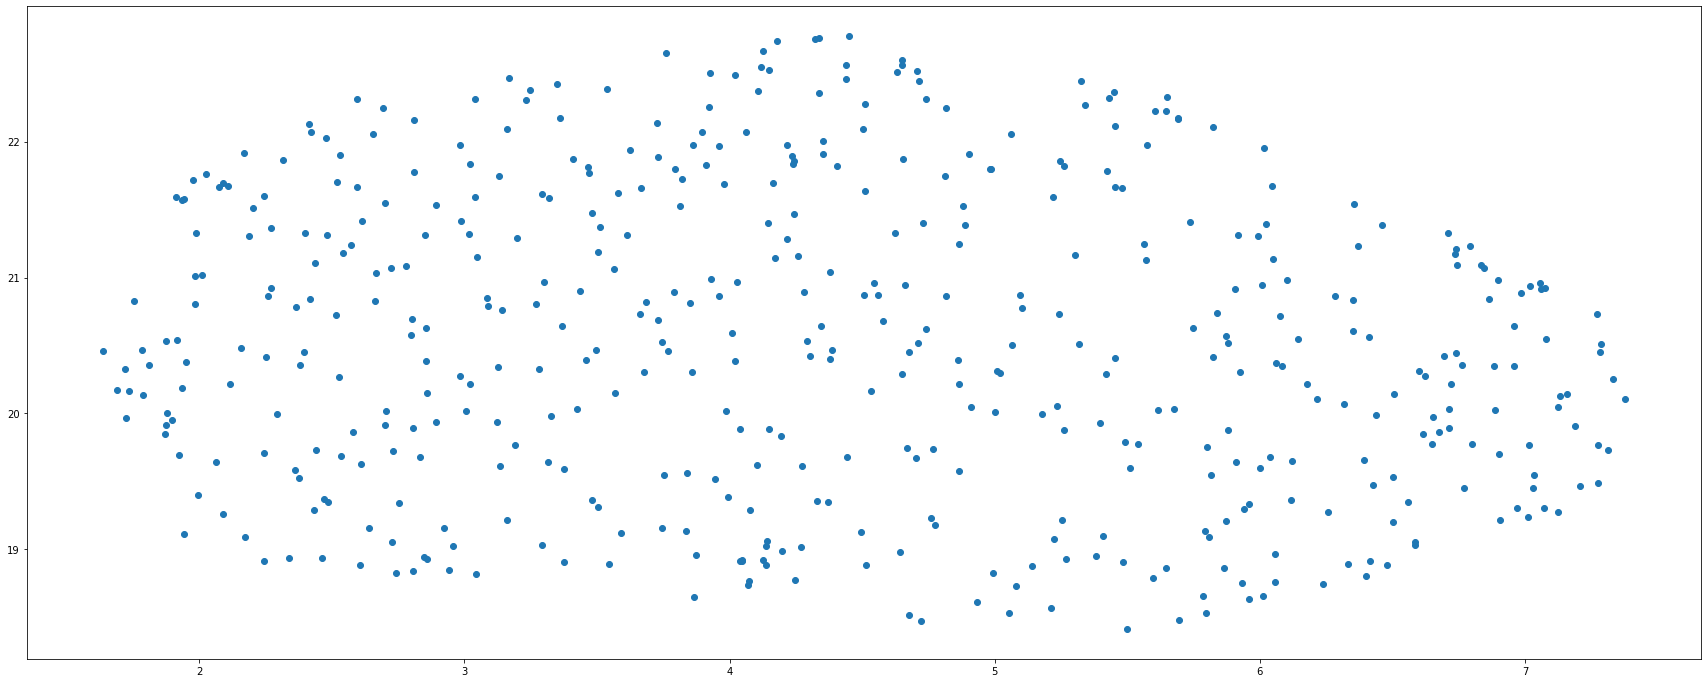

In [154]:
plt.scatter(embedding_sp500[:,0], embedding_sp500[:,1])

Text(0.5, 1.0, 'UMAP projection of the S&P500 and sp500 Index')

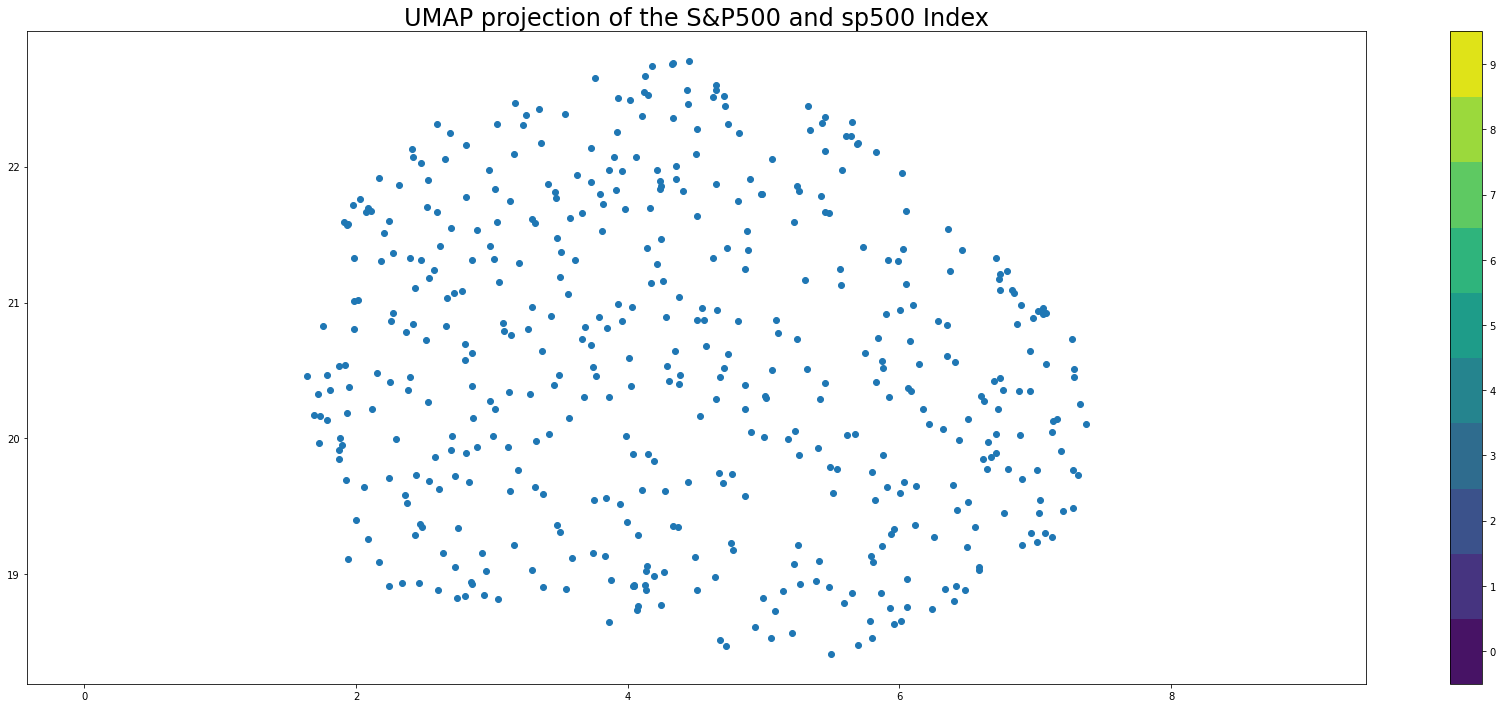

In [155]:
plt.scatter(
    embedding_sp500[:, 0],
    embedding_sp500[:, 1],
    #c=indicators_data
    )
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of the S&P500 and sp500 Index', fontsize=24)

In [156]:
data = sp500_data

In [157]:
def draw_umap(n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(data);
    fig = plt.figure()
    if n_components == 1:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], 
                   range(len(u)), 
                   #c=data
                   )
    if n_components == 2:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], 
                   u[:,1], 
                   #c=data
                   )
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(u[:,0], 
                   u[:,1], 
                   u[:,2], 
                   #c=data
                   )
    plt.title(title, fontsize=18)

In [158]:
#for n in (2, 5, 10, 20, 50, 100, 200,500):
#    draw_umap(n_neighbors=n, title='n_neighbors = {}'.format(n))

In [159]:
#for d in (0.0, 0.1, 0.25, 0.5, 0.8, 0.99):
#    draw_umap(min_dist=d, title='min_dist = {}'.format(d))

/usr/local/lib/python3.7/dist-packages/umap/umap_.py:2345: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  "n_neighbors is larger than the dataset size; truncating to "


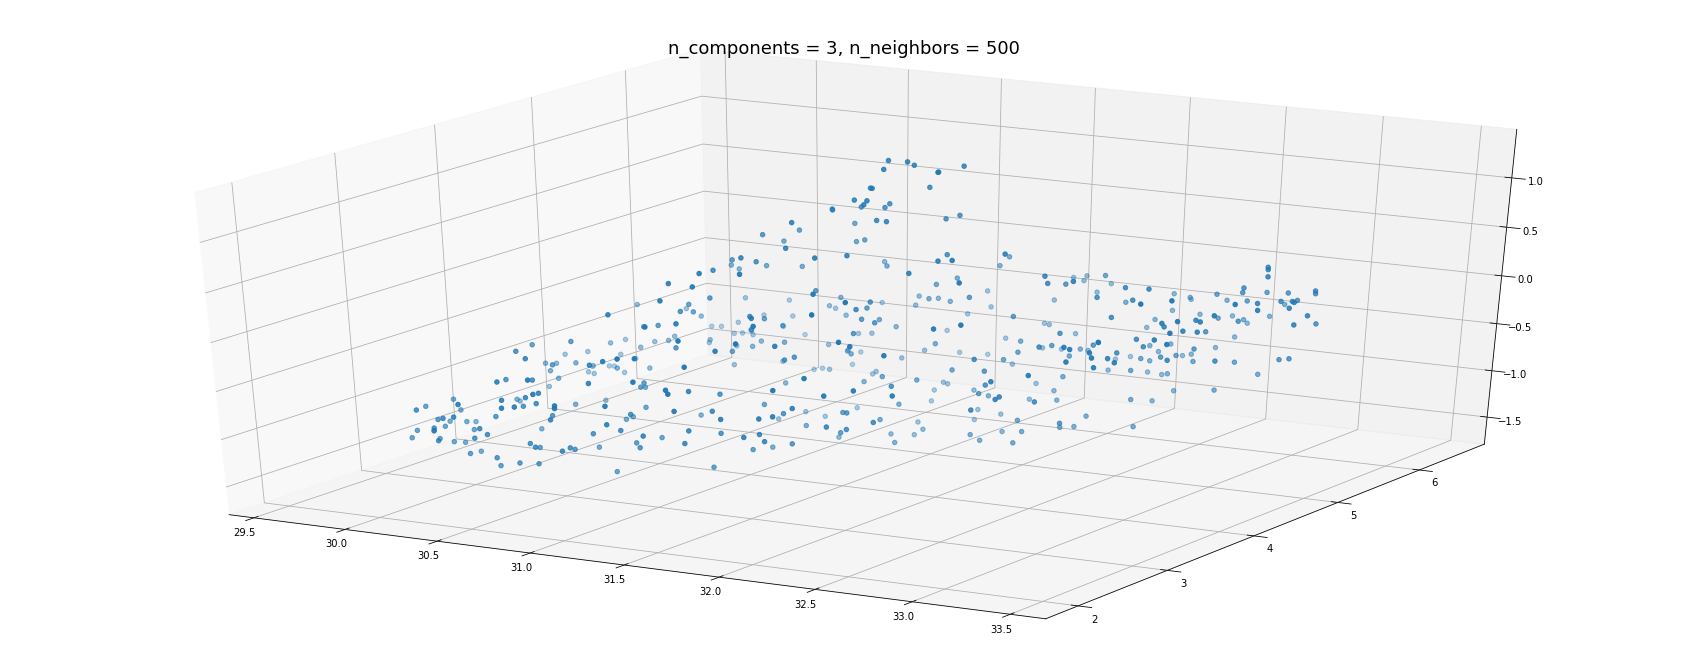

In [160]:
draw_umap(n_components=3,n_neighbors=500, title='n_components = 3, n_neighbors = 500')

##K-Means application for UMAP output

In [161]:
kmeans_input_sp500 = pd.DataFrame(embedding_sp500)
kmeans_input_sp500.rename(columns={0:'x',1:'y'},inplace=True)

In [162]:
columns = ['x','y']
#Normalização dos dados
for column in columns:
  kmeans_input_sp500[column] = (kmeans_input_sp500[column]-min(kmeans_input_sp500[column].dropna()))/(max(kmeans_input_sp500[column].dropna())-min(kmeans_input_sp500[column].dropna()))

In [163]:
X = kmeans_input_sp500.iloc[:,[0,1]].values

In [164]:
import pandas as pd
import matplotlib as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labelencoder_X = LabelEncoder()
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,10
from pandas.plotting import register_matplotlib_converters

from matplotlib import pyplot

from sklearn.metrics import mean_squared_error
from math import sqrt

In [165]:
WCSS = []

In [166]:
for i in range (1,11):
  kmeans_sp500 = KMeans(n_clusters=i,random_state=0)
  kmeans_sp500.fit(X)
  WCSS.append(kmeans_sp500.inertia_)

Text(0, 0.5, 'wcss')

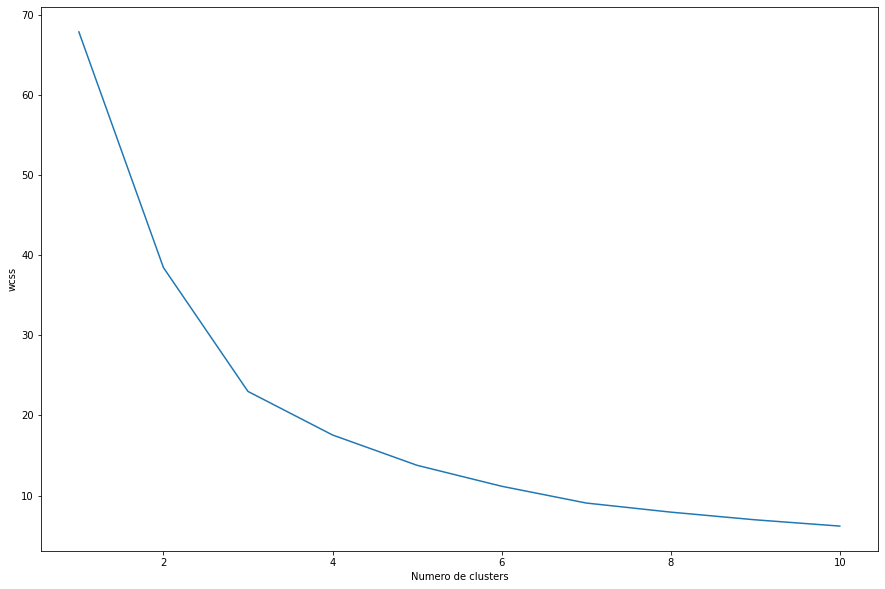

In [167]:
plt.plot(range(1,11),WCSS)
plt.xlabel('Numero de clusters')
plt.ylabel('wcss')

In [168]:
kmeans_sp500 = KMeans(n_clusters=5, random_state=0)
previsoes = kmeans_sp500.fit_predict(X)

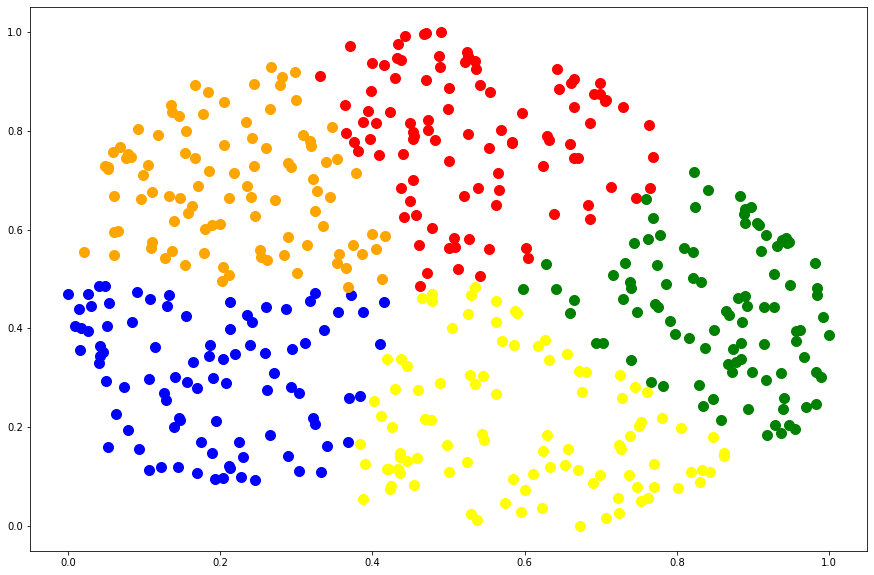

In [169]:
plt.scatter(X[previsoes == 0,0], X[previsoes == 0,1],s=100, c='red', label = 'Cluster 1')
plt.scatter(X[previsoes == 1,0], X[previsoes == 1,1],s=100, c='green', label = 'Cluster 2')
plt.scatter(X[previsoes == 2,0], X[previsoes == 2,1],s=100, c='blue', label = 'Cluster 3')
plt.scatter(X[previsoes == 3,0], X[previsoes == 3,1],s=100, c='yellow', label = 'Cluster 4')
plt.scatter(X[previsoes == 4,0], X[previsoes == 4,1],s=100, c='orange', label = 'Cluster 5')

In [170]:
kmeans_output_sp500 = pd.DataFrame(np.column_stack((kmeans_input_sp500, previsoes)))

In [171]:
kmeans_output_sp500

,0,1,2
0,0.508915,0.563905,0.0
1,0.016809,0.401564,2.0
2,0.628468,0.531059,1.0
3,0.526734,0.580808,0.0
4,0.982292,0.246576,1.0
...,...,...,...
479,0.204325,0.770565,4.0
480,0.404733,0.561194,4.0
481,0.301452,0.511207,4.0
482,0.252242,0.558735,4.0


In [172]:
kmeans_output_sp500 = kmeans_output_sp500.rename(columns={0:'x',1:'y',2:'Cluster'})

In [173]:
#preenchendo a coluna de clusters no dataframe principal
sp500_application['Cluster UMAP K-Means'] = ''
for i in range(0,len(sp500_application)):
  cluster = int(kmeans_output_sp500['Cluster'].iloc[i])
  sp500_application['Cluster UMAP K-Means'].iloc[i] = int(cluster)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [174]:
kmeans_output_sp500.groupby('Cluster',dropna=False).count()

,x,y
Cluster,,
0.0,99,99
1.0,96,96
2.0,92,92
3.0,100,100
4.0,97,97


##K-Means application for the same features used in UMAP

In [175]:
sp500_data.shape

(484, 22)

In [176]:
X = sp500_data#.iloc[:,[0,13]].values

In [177]:
import pandas as pd
import matplotlib as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labelencoder_X = LabelEncoder()
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 30,12
from pandas.plotting import register_matplotlib_converters

from matplotlib import pyplot

from sklearn.metrics import mean_squared_error
from math import sqrt

In [178]:
X

array([[0.26901752, 0.25035981, 0.84501104, ..., 0.16955392, 0.13173712,
        0.96464452],
       [0.0868813 , 0.10622487, 0.82747056, ..., 0.09151971, 0.59196646,
        0.40925442],
       [0.12842459, 0.0270572 , 0.84804766, ..., 0.17153779, 0.16986317,
        0.63422424],
       ...,
       [0.09051822, 0.0824059 , 0.84516404, ..., 0.27386549, 0.3158201 ,
        0.78730134],
       [0.15580159, 0.09064166, 0.86169357, ..., 0.14596321, 0.27580112,
        0.74118044],
       [0.49558509, 0.41444424, 0.84671478, ..., 0.6413864 , 0.08697531,
        0.84671745]])

In [179]:
WCSS = []

In [180]:
for i in range (1,11):
  kmeans_sp500 = KMeans(n_clusters=i,random_state=0)
  kmeans_sp500.fit(X)
  WCSS.append(kmeans_sp500.inertia_)

Text(0, 0.5, 'wcss')

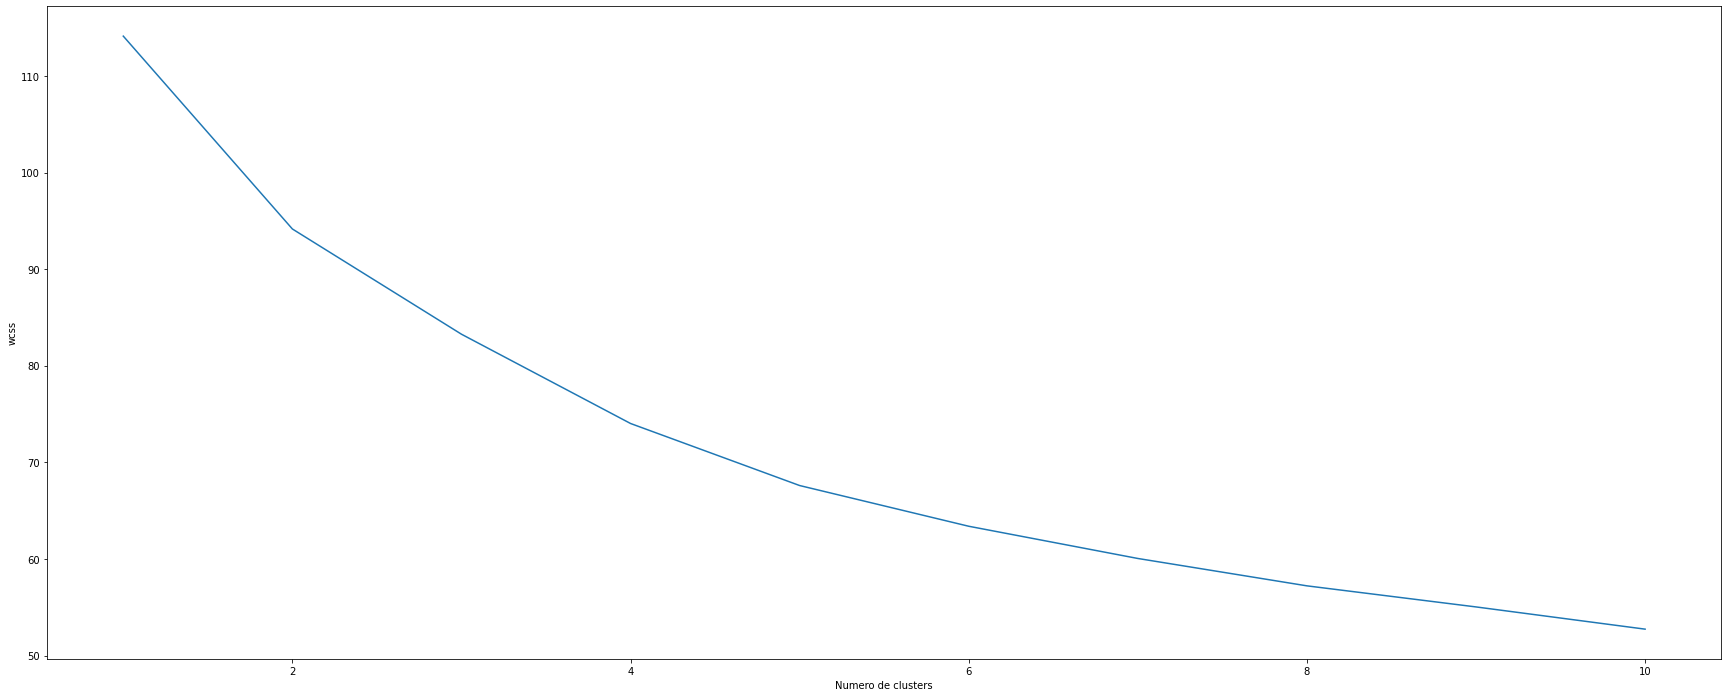

In [181]:
plt.plot(range(1,11),WCSS)
plt.xlabel('Numero de clusters')
plt.ylabel('wcss')

In [182]:
kmeans_sp500 = KMeans(n_clusters=4, random_state=0)
previsoes = kmeans_sp500.fit_predict(X)

In [183]:
kmeans_output_sp500 = pd.DataFrame(np.column_stack((kmeans_input_sp500, previsoes)))

In [184]:
kmeans_output_sp500 = kmeans_output_sp500.rename(columns={0:'x',1:'y',2:'Cluster'})

In [185]:
sp500_application['Cluster k-means'] = ''
for i in range(0,len(sp500_application)):
  cluster = int(kmeans_output_sp500['Cluster'].iloc[i])
  sp500_application['Cluster k-means'].iloc[i] = int(cluster)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [186]:
kmeans_output_sp500.groupby('Cluster',dropna=False).count()

,x,y
Cluster,,
0.0,194,194
1.0,42,42
2.0,92,92
3.0,156,156


In [187]:
sp500_application

,LiqCor consolid:sim*,LiqSec consolid:sim*,Exig / PL consolid:sim*,DivBr/Ebitda de 3 meses consolid:sim*,Margem Liquida de 3 meses consolid:sim*,ROA de 3 meses,ROE de 3 meses,P/L de 3 meses ajust pela infl,Valor Mercado da empresa Em US Dollars em milhares,Patrim Liq Em US Dollars em milhares consolid:sim*,...,Media do fechamento em 1 trimestre Em US Dollars ajust p/ prov,Beta sp500,TIR média trimestral em 3 meses Em moeda orig,Bollinger 90/2 Média Em moeda orig,Volatilidade base trimestral 3 meses Em moeda orig,Sharpe SP500,VAR % base diária confiança: 95% 3 meses Em moeda orig,Max Drd (c/rec) ajust p/ prov 3 meses Em moeda orig,Cluster UMAP K-Means,Cluster k-means
23,0.269018,0.250360,0.845011,0.820302,0.830794,0.509247,0.040649,0.564291,0.014851,0.039118,...,0.029104,0.542159,0.332265,0.028759,0.133001,0.169554,0.131737,0.964645,0,0
47,0.086881,0.106225,0.827471,0.833658,0.743944,0.292273,0.147939,0.553364,0.002271,0.014695,...,0.001893,0.750918,0.167722,0.001985,0.593265,0.091520,0.591966,0.409254,2,2
70,0.128425,0.027057,0.848048,0.826314,0.783503,0.406490,0.039486,0.562335,0.003416,0.034780,...,0.037240,0.533410,0.336390,0.037301,0.169036,0.171538,0.169863,0.634224,1,0
95,0.104327,0.134455,0.850274,0.818328,0.833918,0.703652,0.057296,0.561999,1.000000,0.166791,...,0.001687,0.636613,0.363948,0.002317,0.316858,0.184407,0.319274,1.000000,0,0
119,0.070420,0.088529,0.856935,0.823804,0.832094,0.455569,0.048152,0.559823,0.080580,0.058341,...,0.020407,0.379060,0.580419,0.020217,0.098334,0.637511,0.101016,0.852174,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11087,0.155802,0.090642,0.844797,0.830263,0.757667,0.333247,0.036954,0.526139,0.007398,0.053069,...,0.022906,0.581481,0.161826,0.023896,0.293809,0.054899,0.290319,0.781185,4,0
11110,0.090518,0.082406,0.845164,0.819173,0.798429,0.467834,0.039898,0.569479,0.009210,0.034503,...,0.103957,0.678203,0.257022,0.102693,0.164093,0.093576,0.163972,0.633150,4,0
11111,0.090518,0.082406,0.845164,0.819173,0.798429,0.467834,0.039898,0.569479,0.009210,0.034503,...,0.106009,0.706253,0.460240,0.107447,0.308583,0.273865,0.315820,0.787301,4,0
11135,0.155802,0.090642,0.861694,0.830263,0.757667,0.356244,0.038420,0.558621,0.001671,0.043097,...,0.010280,0.632529,0.326419,0.010112,0.276557,0.145963,0.275801,0.741180,4,0


##PAM

In [188]:
!pip install scikit-learn-extra

In [189]:
# — — — — — — -Importing Packages — — — — — — — — — — — -
import matplotlib.pyplot as plt
import numpy as np
from sklearn_extra.cluster import KMedoids

In [190]:
PAM_input_sp500 = pd.DataFrame(embedding_sp500)
PAM_input_sp500.rename(columns={0:'x',1:'y'},inplace=True)

In [191]:
columns = ['x','y']
#Normalização dos dados
for column in columns:
  PAM_input_sp500[column] = (PAM_input_sp500[column]-min(PAM_input_sp500[column].dropna()))/(max(PAM_input_sp500[column].dropna())-min(PAM_input_sp500[column].dropna()))

In [192]:
X = PAM_input_sp500.iloc[:,[0,1]].values

In [193]:
kmedoids = KMedoids(n_clusters=5, random_state=0).fit(X)

In [194]:
import random

In [195]:
X[random.randint(0, len(kmeans_input_sp500.iloc[:,[0,1]].values))]

array([0.1060657 , 0.29748473], dtype=float32)

In [196]:
kmedoids.predict([X[random.randint(0, len(X))],
                  X[random.randint(0, len(X))],
                  X[random.randint(0, len(X))],
                  X[random.randint(0, len(X))],
                  X[random.randint(0, len(X))]])

array([2, 1, 2, 3, 1])

In [197]:
kmedoids.cluster_centers_

array([[0.82126135, 0.5020259 ],
       [0.16308092, 0.64723796],
       [0.47336537, 0.800738  ],
       [0.26089984, 0.27452618],
       [0.73783493, 0.18237922]], dtype=float32)

In [198]:
kmedoids.inertia_

76.023605

Text(0.5, 1.0, 'KMedoids clustering. Medoids are represented in cyan.')

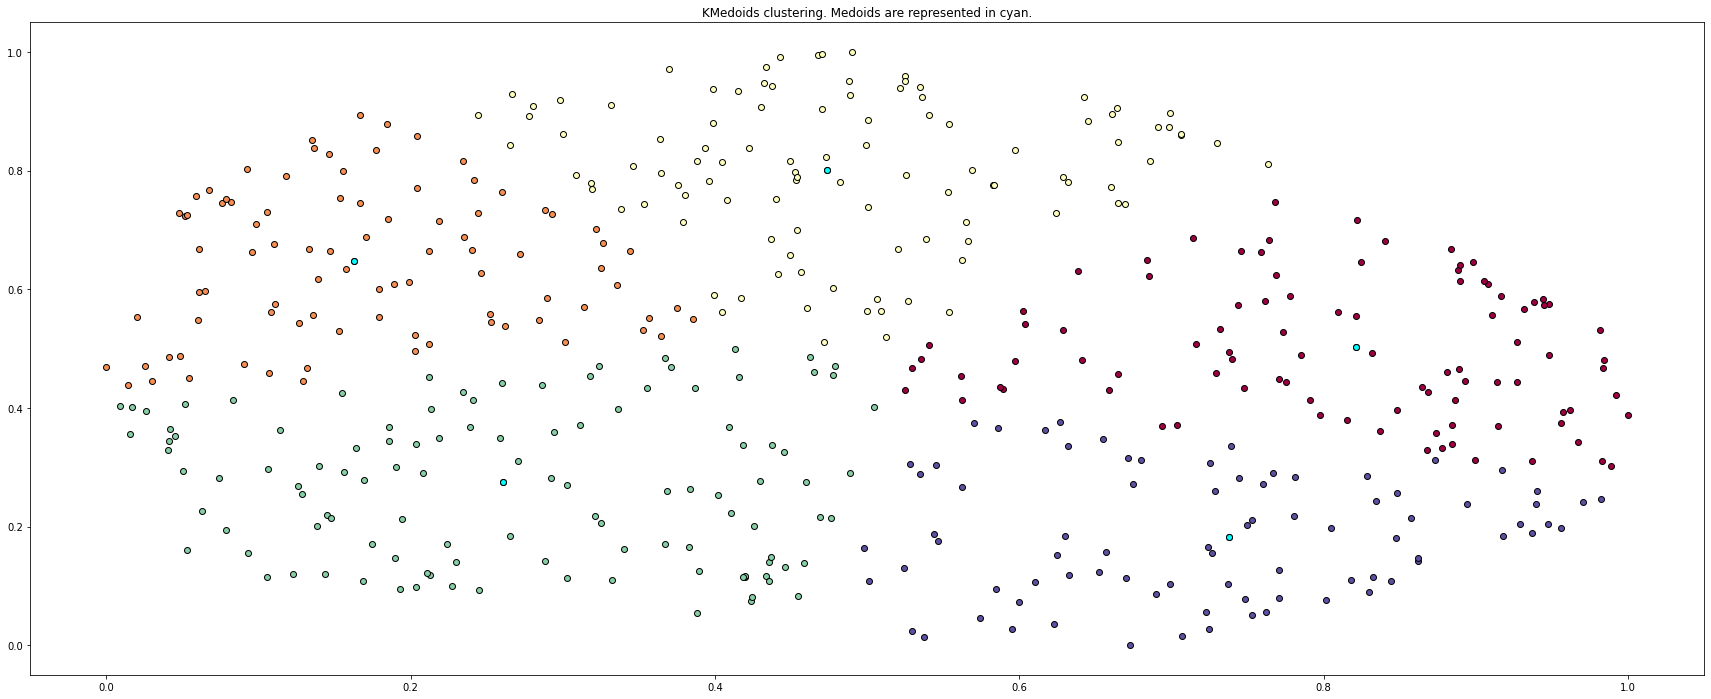

In [199]:
labels = kmedoids.labels_

unique_labels = set(labels)
colors = [
    plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))
]
for k, col in zip(unique_labels, colors):

    class_member_mask = labels == k

    xy = X[class_member_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.plot(
    kmedoids.cluster_centers_[:, 0],
    kmedoids.cluster_centers_[:, 1],
    "o",
    markerfacecolor="cyan",
    markeredgecolor="k",
    markersize=6,
)

plt.title("KMedoids clustering. Medoids are represented in cyan.")

In [200]:
kmedoids.cluster_centers_

array([[0.82126135, 0.5020259 ],
       [0.16308092, 0.64723796],
       [0.47336537, 0.800738  ],
       [0.26089984, 0.27452618],
       [0.73783493, 0.18237922]], dtype=float32)

In [201]:
kmedoids.labels_

array([2, 3, 0, 2, 4, 0, 3, 4, 3, 3, 0, 4, 1, 0, 0, 2, 0, 2, 2, 0, 4, 1,
       3, 1, 2, 3, 3, 4, 0, 2, 0, 2, 4, 4, 4, 4, 3, 4, 4, 0, 0, 3, 0, 2,
       0, 1, 0, 1, 2, 0, 3, 3, 0, 3, 3, 1, 2, 2, 3, 1, 3, 0, 0, 4, 2, 4,
       1, 3, 3, 2, 2, 0, 2, 2, 3, 0, 1, 0, 3, 3, 4, 3, 3, 0, 4, 2, 2, 0,
       0, 1, 2, 4, 2, 2, 2, 0, 4, 0, 1, 2, 1, 0, 0, 3, 3, 4, 2, 4, 0, 1,
       3, 4, 1, 0, 0, 1, 0, 1, 3, 1, 2, 0, 4, 0, 0, 1, 3, 3, 1, 4, 3, 4,
       4, 1, 0, 1, 3, 3, 2, 2, 4, 0, 3, 0, 4, 3, 3, 3, 3, 0, 4, 0, 4, 0,
       0, 3, 0, 3, 0, 4, 3, 4, 4, 3, 4, 3, 4, 3, 2, 0, 4, 1, 1, 2, 1, 3,
       4, 3, 2, 2, 1, 0, 0, 2, 3, 3, 1, 0, 0, 4, 1, 2, 4, 1, 3, 2, 1, 2,
       0, 1, 2, 2, 3, 3, 2, 3, 3, 2, 0, 4, 2, 0, 4, 3, 2, 0, 1, 4, 0, 1,
       3, 1, 4, 2, 2, 3, 4, 4, 3, 1, 4, 3, 3, 2, 4, 2, 2, 4, 2, 2, 2, 4,
       1, 3, 4, 0, 2, 3, 2, 0, 2, 4, 2, 2, 1, 3, 0, 2, 2, 4, 4, 2, 1, 0,
       4, 4, 3, 1, 1, 2, 3, 3, 4, 1, 4, 0, 3, 4, 0, 0, 3, 3, 1, 3, 1, 2,
       2, 4, 0, 2, 3, 2, 1, 1, 3, 3, 1, 2, 1, 2, 0,

In [202]:
sp500_application['Cluster PAM'] = ''
for i in range(0,len(sp500_application)):
  cluster = int(kmedoids.labels_[i])
  sp500_application['Cluster PAM'].iloc[i] = int(cluster)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


## Consolidação

In [203]:
sp500_application.columns

Index([' LiqCor  consolid:sim*', ' LiqSec  consolid:sim*',
       ' Exig / PL  consolid:sim*', ' DivBr/Ebitda  de 3 meses  consolid:sim*',
       ' Margem Liquida  de 3 meses  consolid:sim*', 'ROA de 3 meses',
       'ROE de 3 meses', 'P/L de 3 meses ajust pela infl',
       'Valor Mercado da empresa Em US Dollars em milhares',
       ' Patrim Liq  Em US Dollars  em milhares  consolid:sim*',
       'Price/Book ratio', 'EV Em US Dollars em milhares consolid:sim*',
       'EV/EBITDA emp Em US Dollars de 3 meses consolid:sim*',
       'P/FCF Em US Dollars de 3 meses consolid:sim*',
       'Media do fechamento em 1 trimestre Em US Dollars ajust p/ prov',
       'Beta sp500', 'TIR média trimestral em 3 meses Em moeda orig',
       'Bollinger 90/2 Média Em moeda orig',
       'Volatilidade base trimestral 3 meses Em moeda orig', 'Sharpe SP500',
       'VAR % base diária confiança: 95% 3 meses Em moeda orig',
       'Max Drd (c/rec) ajust p/ prov 3 meses Em moeda orig',
       'Cluster UMAP K

In [204]:
len(sp500_application) - len(df_sp500)

-10676

In [205]:
df_sp500['Cluster UMAP K-Means'] = ''
df_sp500['Cluster k-means'] = ''
df_sp500['Cluster PAM'] = ''

In [206]:
df_sp500.loc[(df_sp500[' Data do Bal  consolid:sim*'].astype(str)>='2021-10-01') & (df_sp500[' Data do Bal  consolid:sim*'].astype(str)<='2021-12-31'),'Cluster UMAP K-Means'] = sp500_application['Cluster UMAP K-Means'].astype(float)
df_sp500.loc[(df_sp500[' Data do Bal  consolid:sim*'].astype(str)>='2021-10-01') & (df_sp500[' Data do Bal  consolid:sim*'].astype(str)<='2021-12-31'),'Cluster k-means'] = sp500_application['Cluster k-means'].astype(float)
df_sp500.loc[(df_sp500[' Data do Bal  consolid:sim*'].astype(str)>='2021-10-01') & (df_sp500[' Data do Bal  consolid:sim*'].astype(str)<='2021-12-31'),'Cluster PAM'] = sp500_application['Cluster PAM'].astype(float)

In [207]:
sp500_dtref = df_sp500.loc[(df_sp500[' Data do Bal  consolid:sim*'].astype(str)>='2021-10-01') & (df_sp500[' Data do Bal  consolid:sim*'].astype(str)<='2021-12-31')]

In [208]:
sp500_dtref[['Cluster UMAP K-Means', 'Cluster k-means', 'Cluster PAM']] = sp500_dtref[['Cluster UMAP K-Means', 'Cluster k-means', 'Cluster PAM']].astype(float)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [209]:
df_sp500.loc[(df_sp500[' Data do Bal  consolid:sim*'].astype(str)>='2021-12-01') & (df_sp500[' Data do Bal  consolid:sim*'].astype(str)<='2021-12-31')][' Data do Bal  consolid:sim*'].drop_duplicates().reset_index().sort_values(by=' Data do Bal  consolid:sim*')

,index,Data do Bal consolid:sim*
4,7127,2021-12-02
2,215,2021-12-03
1,95,2021-12-25
3,4631,2021-12-26
0,47,2021-12-31


In [210]:
df_sp500.loc[(df_sp500[' Data do Bal  consolid:sim*'].astype(str)>='2021-10-01') & (df_sp500[' Data do Bal  consolid:sim*'].astype(str)<='2021-12-31')]['Código'].drop_duplicates().reset_index().sort_values(by='Código')

,index,Código
0,23,A
1,47,AAL
2,70,AAP
3,95,AAPL
4,119,ABBV
...,...,...
458,11063,YUM
459,11087,ZBH
460,11110,ZBRA
461,11135,ZION


# Ts Features

##Reading data

In [738]:
df_ibov_features = pd.read_excel('/content/drive/MyDrive/IC ITA/df_Features_Ibov.xlsx')
df_ibov_features['Indice'] = 'Ibov'

df_sp500_features = pd.read_excel('/content/drive/MyDrive/IC ITA/df_Features_SP500.xlsx').rename(columns={'unique_id':'Código'})
df_sp500_features['Indice'] = 'S&P500'

df_indicators_features = pd.concat([df_sp500_features,df_ibov_features]).drop('Unnamed: 0',axis='columns')

In [739]:
df_indicators_features

,Código,hurst,series_length,unitroot_pp,unitroot_kpss,hw_alpha,hw_beta,hw_gamma,stability,nperiods,...,crossing_points,arch_lm,x_acf1,x_acf10,diff1_acf1,diff1_acf10,diff2_acf1,diff2_acf10,seas_acf1,Indice
0,A,0.409325,23,-28.048995,0.086791,1.490140e-08,1.489508e-08,2.260365e-13,0.000523,1,...,15,1,-0.367334,0.783027,-0.631981,1.194119,-0.729109,1.503309,-0.233997,S&P500
1,AAL,0.444551,23,-18.305093,0.043385,1.490224e-08,1.489431e-08,1.421007e-12,0.010302,1,...,8,1,0.101278,1.272607,-0.217840,0.646837,-0.495520,0.652494,0.037392,S&P500
2,AAP,0.456325,23,-27.906333,0.143533,1.490116e-08,2.910258e-10,0.000000e+00,0.005369,1,...,16,1,-0.434876,0.929963,-0.605135,1.124590,-0.669117,1.210058,-0.333618,S&P500
3,AAPL,0.379082,23,-26.430065,0.158570,1.490272e-08,2.875035e-10,1.639721e-12,0.000258,1,...,16,1,-0.279101,0.555910,-0.440556,0.937416,-0.570956,1.277200,-0.240945,S&P500
4,ABBV,0.376635,23,-26.615092,0.110332,1.490116e-08,1.489613e-08,0.000000e+00,0.007156,1,...,15,1,-0.414487,1.540309,-0.558107,1.857736,-0.597467,1.853404,-0.348933,S&P500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,VALE3,0.334208,23,-33.611740,0.321794,1.490116e-08,2.825846e-10,0.000000e+00,0.004601,1,...,15,1,-0.347456,0.261871,-0.535398,0.723522,-0.658143,1.196353,-0.163097,Ibov
70,VIIA3,0.376266,23,-27.809848,0.107609,1.490168e-08,2.915011e-10,5.650508e-13,0.002836,1,...,16,1,-0.430207,0.927184,-0.596678,1.274089,-0.644703,1.409231,-0.326718,Ibov
71,VIVT3,0.490203,23,-7.253861,0.327952,7.595821e-01,7.595821e-01,0.000000e+00,0.007792,1,...,13,1,0.110174,0.064405,-0.026276,0.088235,-0.429111,0.347862,0.044202,Ibov
72,WEGE3,0.380091,23,-23.865743,0.071488,1.490182e-08,2.904799e-10,6.772401e-13,0.004167,1,...,13,1,-0.220589,0.581730,-0.447667,0.831758,-0.612087,1.195074,-0.226041,Ibov


##EDA

In [740]:
df_indicators_features.isnull().sum()

Código               0
hurst                0
series_length        0
unitroot_pp          0
unitroot_kpss        0
hw_alpha             0
hw_beta              0
hw_gamma             0
stability            0
nperiods             0
seasonal_period      0
trend                0
spike                0
linearity            0
curvature            0
e_acf1               0
e_acf10              0
seasonal_strength    0
peak                 0
trough               0
x_pacf5              0
diff1x_pacf5         0
diff2x_pacf5         0
seas_pacf            0
nonlinearity         0
lumpiness            0
alpha                0
beta                 0
arch_acf             0
garch_acf            0
arch_r2              0
garch_r2             0
flat_spots           0
entropy              0
crossing_points      0
arch_lm              0
x_acf1               0
x_acf10              0
diff1_acf1           0
diff1_acf10          0
diff2_acf1           0
diff2_acf10          0
seas_acf1            0
Indice     

In [741]:
#Cria a coluna Código ajustado, que tem o ".SA" no final do ticker das ações brasileiras
df_indicators_features['Código ajustado']=df_indicators_features['Código']
df_indicators_features.loc[df_indicators_features['Indice']=='Ibov','Código ajustado'] = df_indicators_features.loc[df_indicators_features['Indice']=='Ibov','Código ajustado']+str('.SA')

In [742]:
df_indicators_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 539 entries, 0 to 73
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Código             539 non-null    object 
 1   hurst              539 non-null    float64
 2   series_length      539 non-null    int64  
 3   unitroot_pp        539 non-null    float64
 4   unitroot_kpss      539 non-null    float64
 5   hw_alpha           539 non-null    float64
 6   hw_beta            539 non-null    float64
 7   hw_gamma           539 non-null    float64
 8   stability          539 non-null    float64
 9   nperiods           539 non-null    int64  
 10  seasonal_period    539 non-null    int64  
 11  trend              539 non-null    float64
 12  spike              539 non-null    float64
 13  linearity          539 non-null    float64
 14  curvature          539 non-null    float64
 15  e_acf1             539 non-null    float64
 16  e_acf10            539 non-

In [743]:
df_indicators_features.columns

Index(['Código', 'hurst', 'series_length', 'unitroot_pp', 'unitroot_kpss',
       'hw_alpha', 'hw_beta', 'hw_gamma', 'stability', 'nperiods',
       'seasonal_period', 'trend', 'spike', 'linearity', 'curvature', 'e_acf1',
       'e_acf10', 'seasonal_strength', 'peak', 'trough', 'x_pacf5',
       'diff1x_pacf5', 'diff2x_pacf5', 'seas_pacf', 'nonlinearity',
       'lumpiness', 'alpha', 'beta', 'arch_acf', 'garch_acf', 'arch_r2',
       'garch_r2', 'flat_spots', 'entropy', 'crossing_points', 'arch_lm',
       'x_acf1', 'x_acf10', 'diff1_acf1', 'diff1_acf10', 'diff2_acf1',
       'diff2_acf10', 'seas_acf1', 'Indice', 'Código ajustado'],
      dtype='object')

In [744]:
#normaliza as colunas de formato float
columns = ['hurst', 'series_length', 'unitroot_pp',
       'unitroot_kpss', 'hw_alpha', 'hw_beta', 'hw_gamma', 'stability',
       'nperiods', 'seasonal_period', 'trend', 'spike', 'linearity',
       'curvature', 'e_acf1', 'e_acf10', 'seasonal_strength', 'peak', 'trough',
       'x_pacf5', 'diff1x_pacf5', 'diff2x_pacf5', 'seas_pacf', 'nonlinearity',
       'lumpiness', 'alpha', 'beta', 'arch_acf', 'garch_acf', 'arch_r2',
       'garch_r2', 'flat_spots', 'entropy', 'crossing_points', 'arch_lm',
       'x_acf1', 'x_acf10', 'diff1_acf1', 'diff1_acf10', 'diff2_acf1',
       'diff2_acf10', 'seas_acf1']

for column in columns:
  #indicators_application[column] = indicators_application[column].loc[indicators_application[column].isnull()==False]
  #indicators_application = indicators_application[np.isfinite(indicators_application[column]) == True]
  df_indicators_features[column] = (df_indicators_features[column]-min(df_indicators_features[column].dropna())) /(max(df_indicators_features[column].dropna())-min(df_indicators_features[column].dropna()))

##Models Applications

##UMAP testing

In [745]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns 
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,10

In [746]:
import umap

In [747]:
indicators_application_features = df_indicators_features.drop(['Código','Indice','Código ajustado'],axis='columns').replace('-',0).astype(float)
indicators_application_features = indicators_application_features.fillna(0)

In [748]:
indicators_application_features = indicators_application_features.fillna(0)

In [749]:
indicators_data_features = indicators_application_features[columns].values
scaled_indicators_data = StandardScaler().fit_transform(indicators_data_features)

In [750]:
indicators_data_features.shape

(539, 42)

In [751]:
reducer = umap.UMAP()

In [752]:
embedding = reducer.fit_transform(indicators_data_features)
embedding.shape 

(539, 2)

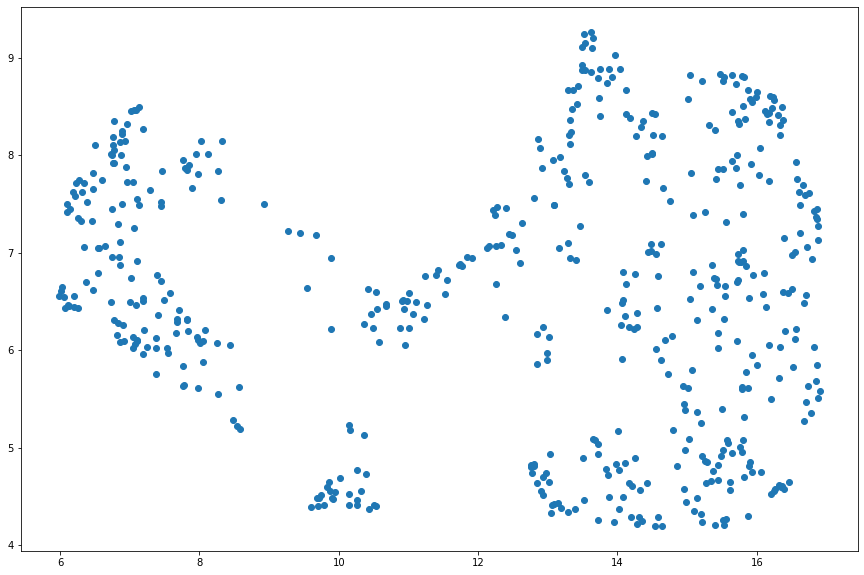

In [753]:
plt.scatter(embedding[:,0], embedding[:,1])

Text(0.5, 1.0, 'UMAP projection of the S&P500 and Ibov Index')

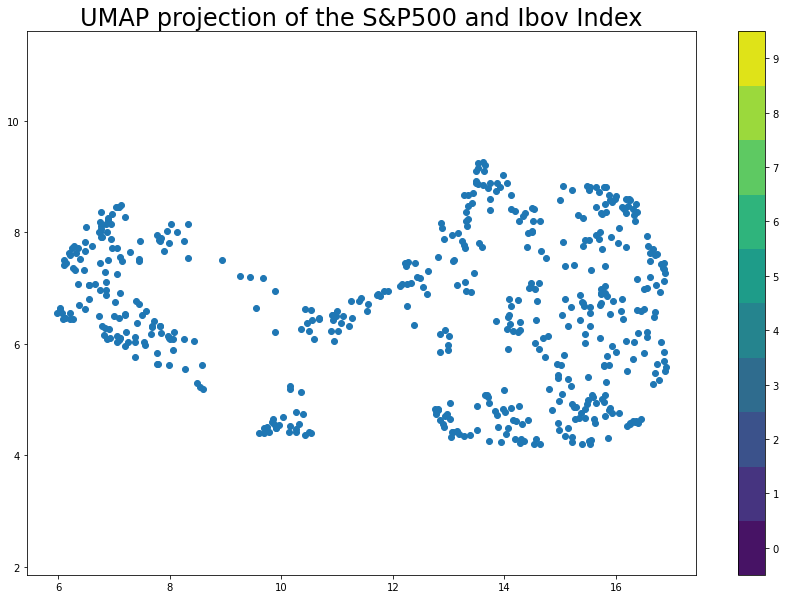

In [754]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    #c=indicators_data
    )
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of the S&P500 and Ibov Index', fontsize=24)

In [755]:
data = indicators_data_features 

In [756]:
def draw_umap(n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(data);
    fig = plt.figure()
    if n_components == 1:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], 
                   range(len(u)), 
                   #c=data
                   )
    if n_components == 2:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], 
                   u[:,1], 
                   #c=data
                   )
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(u[:,0], 
                   u[:,1], 
                   u[:,2], 
                   #c=data
                   )
    plt.title(title, fontsize=18)

In [757]:
#for n in (2, 5, 10, 20, 50, 100, 200,300,400,500):
#    draw_umap(n_neighbors=n, title='n_neighbors = {}'.format(n))

In [758]:
#for d in (0.0, 0.1, 0.25, 0.5, 0.8, 0.99):
#    draw_umap(min_dist=d, title='min_dist = {}'.format(d))

In [759]:
len(indicators_data_features)

539

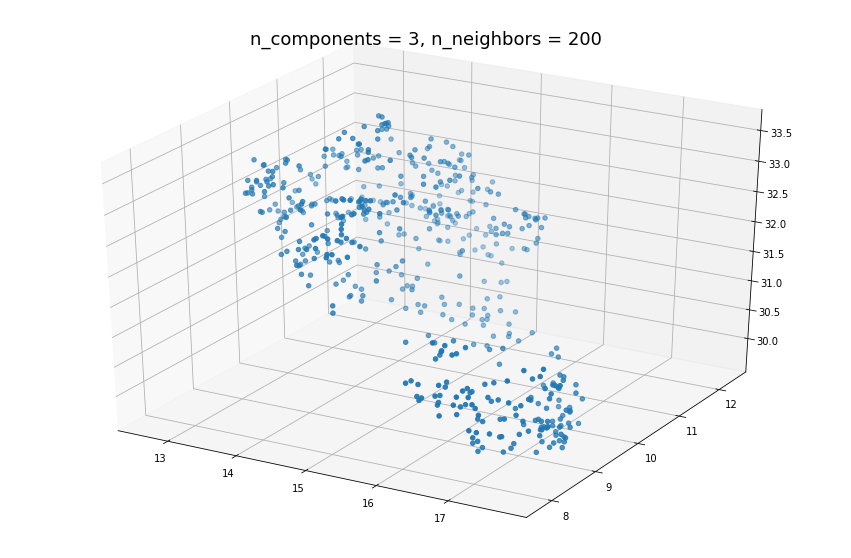

In [760]:
draw_umap(n_components=3,n_neighbors=200, title='n_components = 3, n_neighbors = 200')

##K-Means application for UMAP output

In [761]:
kmeans_input = pd.DataFrame(embedding)
kmeans_input.rename(columns={0:'x',1:'y'},inplace=True)

In [762]:
columns = ['x','y']
#Normalização dos dados
for column in columns:
  kmeans_input[column] = (kmeans_input[column]-min(kmeans_input[column].dropna()))/(max(kmeans_input[column].dropna())-min(kmeans_input[column].dropna()))

In [763]:
X = kmeans_input.iloc[:,[0,1]].values

In [764]:
import pandas as pd
import matplotlib as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labelencoder_X = LabelEncoder()
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,10
from pandas.plotting import register_matplotlib_converters

from matplotlib import pyplot

from sklearn.metrics import mean_squared_error
from math import sqrt

In [765]:
WCSS = []

In [766]:
for i in range (1,11):
  kmeans = KMeans(n_clusters=i,random_state=0)
  kmeans.fit(X)
  WCSS.append(kmeans.inertia_)

Text(0, 0.5, 'wcss')

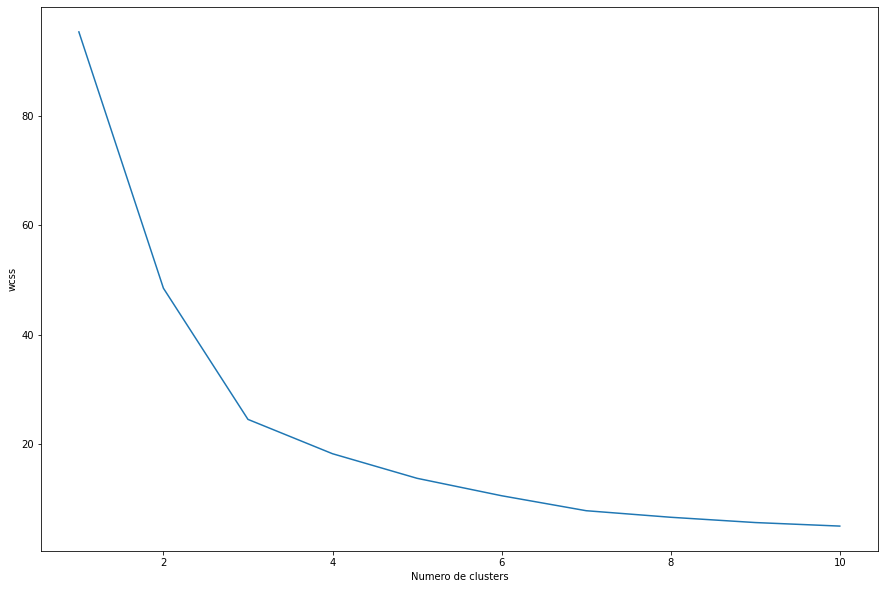

In [767]:
plt.plot(range(1,11),WCSS)
plt.xlabel('Numero de clusters')
plt.ylabel('wcss')

In [768]:
kmeans = KMeans(n_clusters=3, random_state=0)
previsoes = kmeans.fit_predict(X)

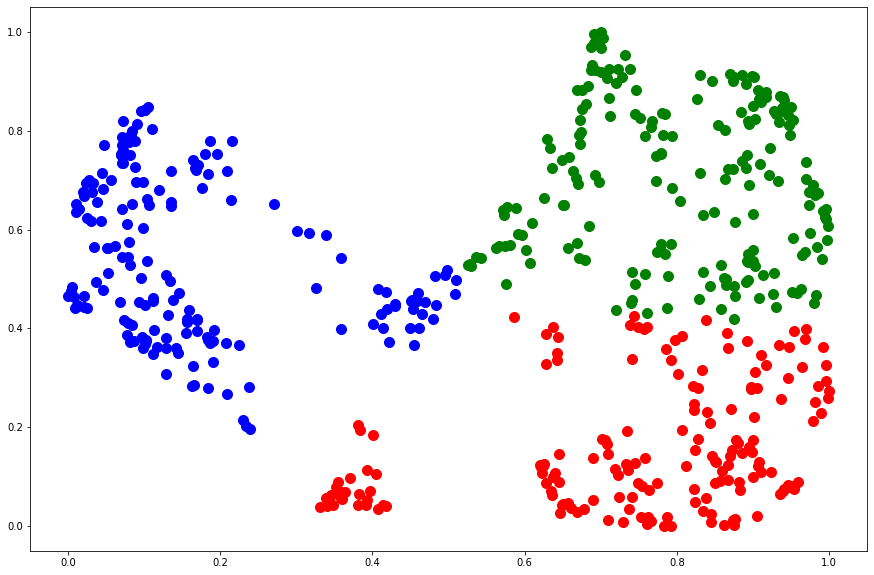

In [769]:
plt.scatter(X[previsoes == 0,0], X[previsoes == 0,1],s=100, c='red', label = 'Cluster 1')
plt.scatter(X[previsoes == 1,0], X[previsoes == 1,1],s=100, c='green', label = 'Cluster 2')
plt.scatter(X[previsoes == 2,0], X[previsoes == 2,1],s=100, c='blue', label = 'Cluster 3')
plt.scatter(X[previsoes == 3,0], X[previsoes == 3,1],s=100, c='yellow', label = 'Cluster 4')
plt.scatter(X[previsoes == 4,0], X[previsoes == 4,1],s=100, c='orange', label = 'Cluster 5')

In [770]:
kmeans_output = pd.DataFrame(np.column_stack((kmeans_input, previsoes)))

In [771]:
kmeans_output

,0,1,2
0,0.031340,0.676934,2.0
1,0.417138,0.473705,2.0
2,0.134996,0.654830,2.0
3,0.792181,0.337052,0.0
4,0.849380,0.634936,1.0
...,...,...,...
534,0.358890,0.056808,0.0
535,0.861836,0.502076,1.0
536,0.344895,0.061924,0.0
537,0.143857,0.349890,2.0


In [772]:
kmeans_output = kmeans_output.rename(columns={0:'x',1:'y',2:'Cluster'})

In [773]:
#preenchendo a coluna de clusters no dataframe principal
indicators_application_features['Cluster UMAP K-Means'] = ''
for i in range(0,len(indicators_application_features)):
  cluster = int(kmeans_output['Cluster'].iloc[i])
  indicators_application_features['Cluster UMAP K-Means'].iloc[i] = int(cluster)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [774]:
kmeans_output.groupby('Cluster',dropna=False).count()

,x,y
Cluster,,
0.0,174,174
1.0,195,195
2.0,170,170


##PAM

In [775]:
!pip install scikit-learn-extra

In [776]:
# — — — — — — -Importing Packages — — — — — — — — — — — -
from sklearn_extra.cluster import KMedoids

In [777]:
X = kmeans_input.iloc[:,[0,1]].values

In [778]:
kmedoids = KMedoids(n_clusters=3, random_state=0).fit(X)

In [779]:
import random

In [780]:
kmeans_input

,x,y
0,0.031340,0.676934
1,0.417138,0.473705
2,0.134996,0.654830
3,0.792181,0.337052
4,0.849380,0.634936
...,...,...
534,0.358890,0.056808
535,0.861836,0.502076
536,0.344895,0.061924
537,0.143857,0.349890


In [781]:
kmedoids.predict([X[random.randint(0, len(X))],
                  X[random.randint(0, len(X))],
                  X[random.randint(0, len(X))]])

array([2, 0, 2])

In [782]:
kmedoids.cluster_centers_

array([[0.12902707, 0.50857294],
       [0.79389256, 0.6847544 ],
       [0.7581225 , 0.13689901]], dtype=float32)

Text(0.5, 1.0, 'KMedoids clustering. Medoids are represented in cyan.')

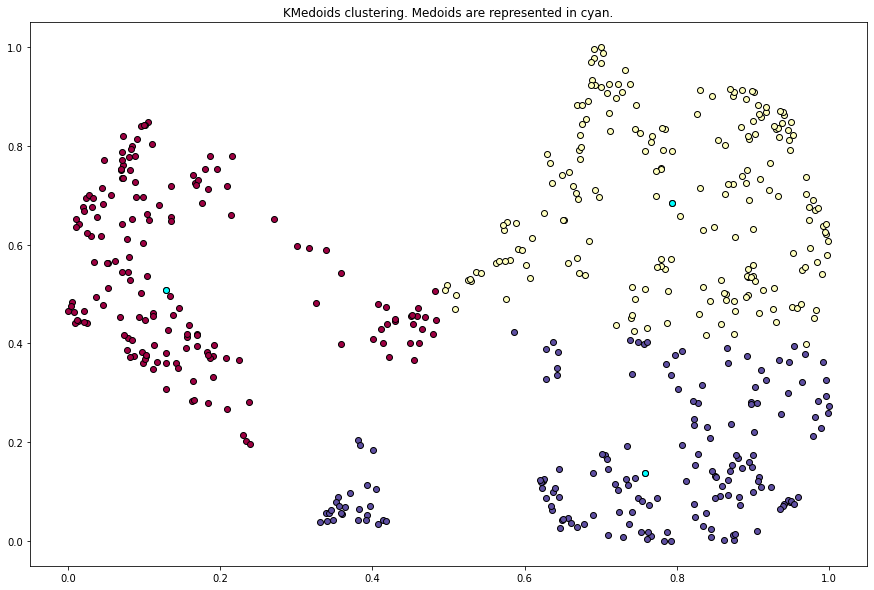

In [783]:
labels = kmedoids.labels_

unique_labels = set(labels)
colors = [
    plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))
]
for k, col in zip(unique_labels, colors):

    class_member_mask = labels == k

    xy = X[class_member_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.plot(
    kmedoids.cluster_centers_[:, 0],
    kmedoids.cluster_centers_[:, 1],
    "o",
    markerfacecolor="cyan",
    markeredgecolor="k",
    markersize=6,
)

plt.title("KMedoids clustering. Medoids are represented in cyan.")

In [784]:
indicators_application_features['Cluster PAM'] = ''
for i in range(0,len(indicators_application_features)):
  cluster = int(kmedoids.labels_[i])
  indicators_application_features['Cluster PAM'].iloc[i] = int(cluster)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


##Hierarquical

In [785]:
Y = kmeans_input
Y

,x,y
0,0.031340,0.676934
1,0.417138,0.473705
2,0.134996,0.654830
3,0.792181,0.337052
4,0.849380,0.634936
...,...,...
534,0.358890,0.056808
535,0.861836,0.502076
536,0.344895,0.061924
537,0.143857,0.349890


<Figure size 21600x21600 with 0 Axes>

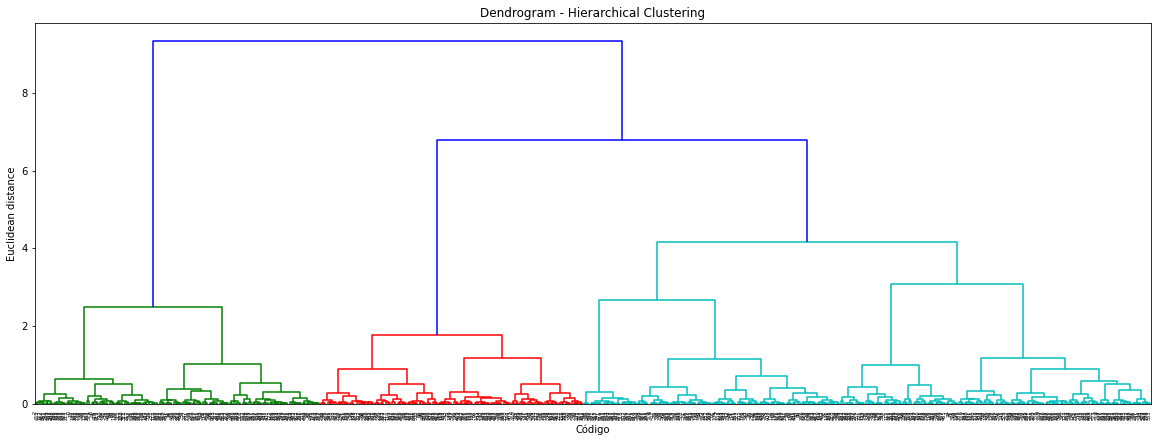

<Figure size 21600x21600 with 0 Axes>

In [786]:
import scipy.cluster.hierarchy as sc

# Plot dendrogram
plt.figure(figsize=(20, 7))  
plt.title("Dendrograms")  

# Create dendrogram
sc.dendrogram(sc.linkage(Y, method='ward'))

plt.title('Dendrogram - Hierarchical Clustering')
plt.xlabel('Código')
plt.ylabel('Euclidean distance')
plt.figure(figsize = (300, 300))

In [787]:
from sklearn.cluster import AgglomerativeClustering

In [788]:
cluster_hierarquical = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
hierarquical = cluster_hierarquical.fit(Y)

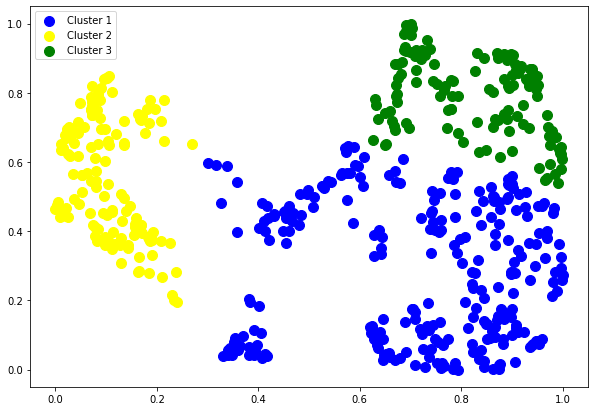

In [789]:
indicators = Y.values

plt.figure(figsize=(10, 7))
plt.scatter(indicators[hierarquical.labels_ == 0, 0], indicators[hierarquical.labels_ == 0, 1], s = 100, c = 'blue', label = 'Cluster 1')
plt.scatter(indicators[hierarquical.labels_ == 1, 0], indicators[hierarquical.labels_ == 1, 1], s = 100, c = 'yellow', label = 'Cluster 2')
plt.scatter(indicators[hierarquical.labels_ == 2, 0], indicators[hierarquical.labels_ == 2, 1], s = 100, c = 'green', label = 'Cluster 3')
plt.legend()
plt.show()

In [790]:
hierarquical_output = pd.DataFrame(np.column_stack((kmeans_input, hierarquical.labels_)))

In [791]:
hierarquical_output = hierarquical_output.rename(columns={0:'x',1:'y',2:'Cluster'})

In [792]:
indicators_application_features['Cluster Hierarquical'] = ''
for i in range(0,len(indicators_application_features)):
  cluster = int(hierarquical_output['Cluster'].iloc[i])
  indicators_application_features['Cluster Hierarquical'].iloc[i] = int(cluster)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


## Consolidação

In [793]:
df_indicators_features.columns

Index(['Código', 'hurst', 'series_length', 'unitroot_pp', 'unitroot_kpss',
       'hw_alpha', 'hw_beta', 'hw_gamma', 'stability', 'nperiods',
       'seasonal_period', 'trend', 'spike', 'linearity', 'curvature', 'e_acf1',
       'e_acf10', 'seasonal_strength', 'peak', 'trough', 'x_pacf5',
       'diff1x_pacf5', 'diff2x_pacf5', 'seas_pacf', 'nonlinearity',
       'lumpiness', 'alpha', 'beta', 'arch_acf', 'garch_acf', 'arch_r2',
       'garch_r2', 'flat_spots', 'entropy', 'crossing_points', 'arch_lm',
       'x_acf1', 'x_acf10', 'diff1_acf1', 'diff1_acf10', 'diff2_acf1',
       'diff2_acf10', 'seas_acf1', 'Indice', 'Código ajustado'],
      dtype='object')

In [794]:
len(indicators_application_features) - len(df_indicators_features)

0

In [795]:
df_indicators_features['Cluster UMAP K-Means'] = indicators_application_features['Cluster UMAP K-Means'].astype(float)
df_indicators_features['Cluster PAM'] = indicators_application_features['Cluster PAM'].astype(float)
df_indicators_features['Cluster Hierarquical'] = indicators_application_features['Cluster Hierarquical'].astype(float)

# Analysis

-----------------------------------------------------------
##Análise da distribuição de ações por cluster em cada modelo
-----------------------------------------------------------

In [796]:
import seaborn as sns
## Figure and plot defaults
plt.rcParams['figure.figsize'] = (18,6) # Increase the default size of plots
plt.subplots_adjust(wspace = 1.5)

<Figure size 1296x432 with 0 Axes>

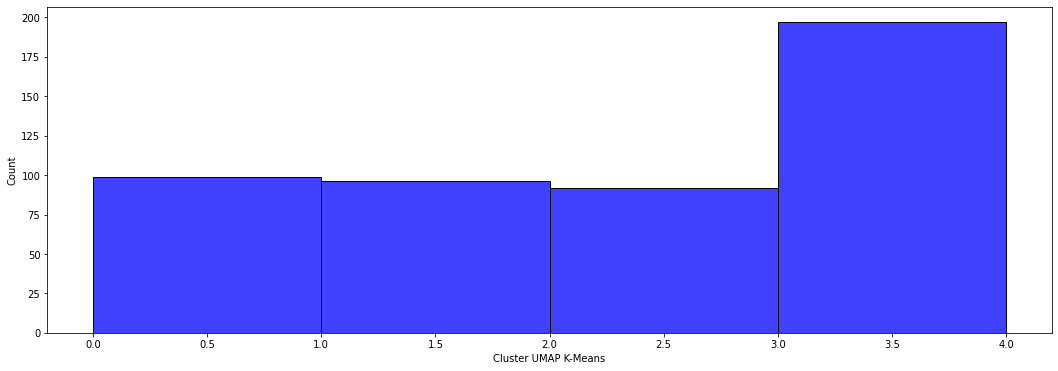

In [797]:
sns.histplot(sp500_dtref['Cluster UMAP K-Means'], color='blue',bins=4)

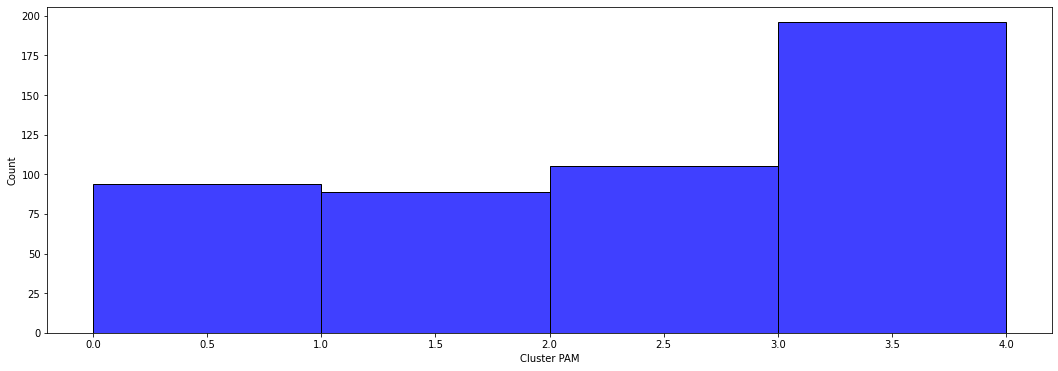

In [798]:
sns.histplot(sp500_dtref['Cluster PAM'], color='blue',bins=4)

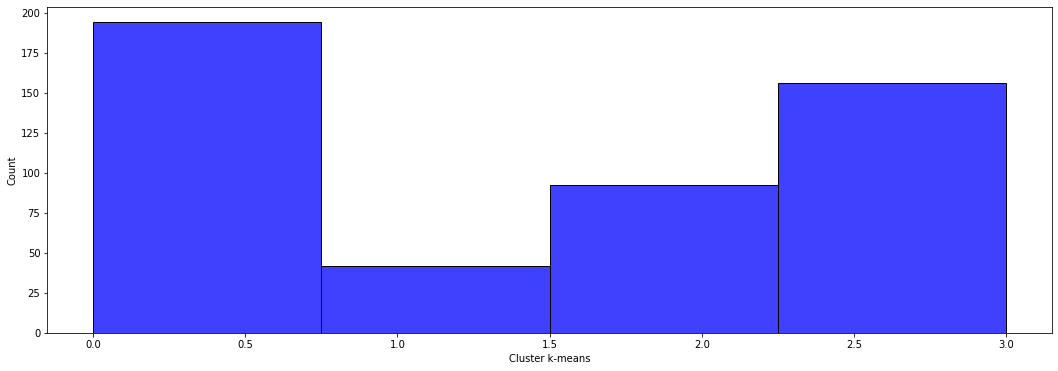

In [799]:
sns.histplot(sp500_dtref['Cluster k-means'], color='blue',bins=4)

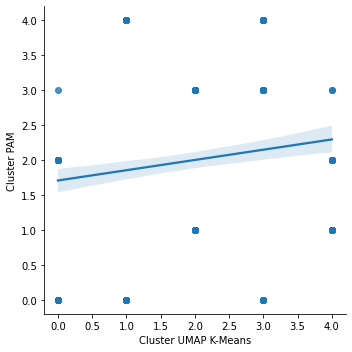

In [800]:
sns.lmplot(x ='Cluster UMAP K-Means', y ='Cluster PAM', data = sp500_dtref)

In [801]:
sp500_dtref[['Cluster UMAP K-Means', 'Cluster PAM', 'Cluster k-means']].corr()

,Cluster UMAP K-Means,Cluster PAM,Cluster k-means
Cluster UMAP K-Means,1.000000,0.152738,-0.066977
Cluster PAM,0.152738,1.000000,0.033146
Cluster k-means,-0.066977,0.033146,1.000000


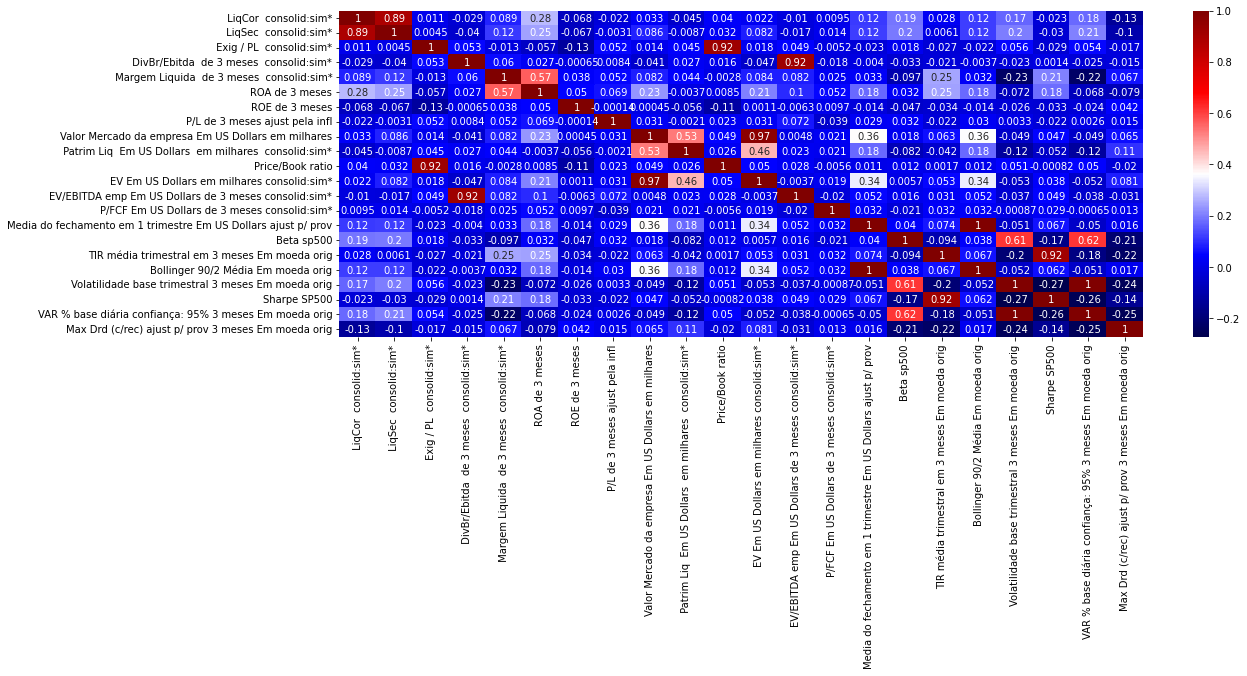

In [802]:
g = sns.heatmap(
    sp500_dtref[[' LiqCor  consolid:sim*', ' LiqSec  consolid:sim*',
       ' Exig / PL  consolid:sim*', ' DivBr/Ebitda  de 3 meses  consolid:sim*',
       ' Margem Liquida  de 3 meses  consolid:sim*', 'ROA de 3 meses',
       'ROE de 3 meses', 'P/L de 3 meses ajust pela infl',
       'Valor Mercado da empresa Em US Dollars em milhares',
       ' Patrim Liq  Em US Dollars  em milhares  consolid:sim*',
       'Price/Book ratio', 'EV Em US Dollars em milhares consolid:sim*',
       'EV/EBITDA emp Em US Dollars de 3 meses consolid:sim*',
       'P/FCF Em US Dollars de 3 meses consolid:sim*',
       'Media do fechamento em 1 trimestre Em US Dollars ajust p/ prov',
       'Beta sp500', 'TIR média trimestral em 3 meses Em moeda orig',
       'Bollinger 90/2 Média Em moeda orig',
       'Volatilidade base trimestral 3 meses Em moeda orig', 'Sharpe SP500',
       'VAR % base diária confiança: 95% 3 meses Em moeda orig',
       'Max Drd (c/rec) ajust p/ prov 3 meses Em moeda orig'  ]].corr(), 
    annot = True, 
    fmt=
    '.2g',
    cmap= 'seismic')

-----------------------------------------------------------
##Seleção dos clusters ótimos e ensemble


---
Equação de seleção do cluster ótimo:

\begin{equation}
\ cluster ótimo \ = max(\frac{Liq. Corrente + Liq. Seca + Margem Líq. + ROA + ROE + TIR + Sharpe}{(\frac{Dívida}{EBITDA}\ + \frac{P}{L}\ + \frac{EV}{EBITDA}\ + \frac{P}{FCF}\ + Volatilidade + Variância + Máx. Drawdoun + \frac{Exigível}{PL}\ + \frac{Price}{Book Ratio}\ + Beta})\
\end{equation}



###Concatenado

In [804]:
df_indicators_dtref['max'] = df_indicators_dtref[' LiqCor  consolid:sim*']+df_indicators_dtref[' LiqSec  consolid:sim*']+df_indicators_dtref[' Margem Liquida  de 3 meses  consolid:sim*']+df_indicators_dtref['ROA de 3 meses']+df_indicators_dtref['ROE de 3 meses']+df_indicators_dtref['TIR média trimestral em 3 meses Em moeda orig']+df_indicators_dtref['Sharpe Ratio']

df_indicators_dtref['min'] = df_indicators_dtref[' DivBr/Ebitda  de 3 meses  consolid:sim*']+df_indicators_dtref['P/L de 3 meses ajust pela infl']+df_indicators_dtref['EV/EBITDA emp Em US Dollars de 3 meses consolid:sim*']+df_indicators_dtref['P/FCF Em US Dollars de 3 meses consolid:sim*']+df_indicators_dtref['Volatilidade base trimestral 3 meses Em moeda orig']+df_indicators_dtref['VAR % base diária confiança: 95% 3 meses Em moeda orig']+df_indicators_dtref['Max Drd (c/rec) ajust p/ prov 3 meses Em moeda orig']+df_indicators_dtref[' Exig / PL  consolid:sim*']+df_indicators_dtref['Price/Book ratio']+df_indicators_dtref['Beta']

df_indicators_dtref['Cluster_select'] = df_indicators_dtref['max']/df_indicators_dtref['min']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [828]:
Cluster_select_UMAP_KMeans = df_indicators_dtref.groupby(['Cluster UMAP K-Means'],dropna=False).mean().sort_values(by='Cluster_select',ascending=False)
stocks_kmeans = df_indicators_dtref.loc[df_indicators_dtref['Cluster UMAP K-Means'].astype(int)== int(Cluster_select_UMAP_KMeans.reset_index()['Cluster UMAP K-Means'].iloc[0])]

In [829]:
Cluster_select_PAM = df_indicators_dtref.groupby(['Cluster PAM'],dropna=False).mean().sort_values(by='Cluster_select',ascending=False)
stocks_pam = df_indicators_dtref.loc[df_indicators_dtref['Cluster PAM'].astype(int)== int(Cluster_select_PAM.reset_index()['Cluster PAM'].iloc[0])]

In [830]:
Cluster_select_Hierarquical = df_indicators_dtref.groupby(['Cluster Hierarquical'],dropna=False).mean().sort_values(by='Cluster_select',ascending=False)
stocks_hierarquical = df_indicators_dtref.loc[df_indicators_dtref['Cluster Hierarquical'].astype(int)== int(Cluster_select_Hierarquical.reset_index()['Cluster Hierarquical'].iloc[0])]

In [832]:
mv_input_total = pd.merge(stocks_kmeans['Código'],stocks_pam['Código'],on='Código',how='inner')
mv_input_total = pd.merge(mv_input_total['Código'],stocks_hierarquical['Código'],on='Código',how='inner')
mv_input_total = pd.merge(mv_input_total,df_indicators_dtref,on='Código',how='inner')

In [834]:
mv_input_total['Código'].drop_duplicates()

0        AAPL
1        ABBV
2         ABT
3         ADM
4         ADP
        ...  
168     RENT3
169    SULA11
170     SUZB3
171     TOTS3
172     VALE3
Name: Código, Length: 173, dtype: object

###S&P500

In [434]:
duvida =  '''
sp500_dtref['Valor Mercado da empresa Em US Dollars em milhares'],
sp500_dtref[' Patrim Liq  Em US Dollars  em milhares  consolid:sim*'],
sp500_dtref['EV Em US Dollars em milhares consolid:sim*'],
sp500_dtref['Media do fechamento em 1 trimestre Em US Dollars ajust p/ prov'],
sp500_dtref['Bollinger 90/2 Média Em moeda orig'],
'''

In [435]:
sp500_dtref['max'] = sp500_dtref[' LiqCor  consolid:sim*']+sp500_dtref[' LiqSec  consolid:sim*']+sp500_dtref[' Margem Liquida  de 3 meses  consolid:sim*']+sp500_dtref['ROA de 3 meses']+sp500_dtref['ROE de 3 meses']+sp500_dtref['TIR média trimestral em 3 meses Em moeda orig']+sp500_dtref['Sharpe SP500']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [436]:
sp500_dtref['min'] = sp500_dtref[' DivBr/Ebitda  de 3 meses  consolid:sim*']+sp500_dtref['P/L de 3 meses ajust pela infl']+sp500_dtref['EV/EBITDA emp Em US Dollars de 3 meses consolid:sim*']+sp500_dtref['P/FCF Em US Dollars de 3 meses consolid:sim*']+sp500_dtref['Volatilidade base trimestral 3 meses Em moeda orig']+sp500_dtref['VAR % base diária confiança: 95% 3 meses Em moeda orig']+sp500_dtref['Max Drd (c/rec) ajust p/ prov 3 meses Em moeda orig']+sp500_dtref[' Exig / PL  consolid:sim*']+sp500_dtref['Price/Book ratio']+sp500_dtref['Beta sp500']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [437]:
sp500_dtref['Cluster_select'] = sp500_dtref['max']/sp500_dtref['min']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [438]:
sp500_dtref.groupby(['Cluster UMAP K-Means'],dropna=False).mean().sort_values(by='Cluster_select',ascending=False)

,LiqCor consolid:sim*,LiqSec consolid:sim*,Exig / PL consolid:sim*,DivBr/Ebitda de 3 meses consolid:sim*,Margem Liquida de 3 meses consolid:sim*,ROA de 3 meses,ROE de 3 meses,P/L de 3 meses ajust pela infl,Valor Mercado da empresa Em US Dollars em milhares,Patrim Liq Em US Dollars em milhares consolid:sim*,...,Bollinger 90/2 Média Em moeda orig,Volatilidade base trimestral 3 meses Em moeda orig,Sharpe SP500,VAR % base diária confiança: 95% 3 meses Em moeda orig,Max Drd (c/rec) ajust p/ prov 3 meses Em moeda orig,Cluster k-means,Cluster PAM,max,min,Cluster_select
Cluster UMAP K-Means,,,,,,,,,,,,,,,,,,,,,
3.0,2.808694,2.225945,179.713907,7.666879,20.171773,3.188147,14.204468,-36.185521,9.213165e+07,1.338018e+07,...,302.619708,12.836053,3.773452,2.663724,-5.937677,1.980000,3.420000,62.079791,274.558084,0.101812
1.0,1.091342,0.855291,-821.608109,15.791589,18.075650,1.806165,18.263504,145.692358,8.300626e+07,1.578838e+07,...,192.783111,9.692998,4.294856,2.006444,-5.436137,2.875000,0.791667,59.438279,-602.769189,0.097474
2.0,1.732877,1.350658,185.385706,6.731855,8.290317,2.215756,19.276310,104.846597,6.730407e+07,1.081718e+07,...,153.787157,18.171450,0.936991,3.764063,-9.132134,1.684783,2.760870,38.906467,363.241632,0.064442
4.0,1.340927,1.093094,294.476556,13.045580,9.547148,1.412766,5.837856,132.730354,4.852861e+07,1.494744e+07,...,174.915579,16.118998,-0.038163,3.316187,-2.988264,0.381443,1.216495,16.392719,278.607809,0.023344
0.0,1.223484,0.928521,185.944395,-0.417265,12.661048,1.737882,54.601550,66.868107,1.612711e+08,3.888752e+07,...,188.789453,10.825150,0.468589,2.230776,-2.416465,0.282828,1.808081,73.250832,341.016947,0.021811


In [439]:
stocks_kmeans = sp500_dtref.loc[sp500_dtref['Cluster UMAP K-Means'].astype(int)==4]

In [440]:
sp500_dtref.groupby(['Cluster PAM'],dropna=False).mean().sort_values(by='Cluster_select',ascending=False)

,LiqCor consolid:sim*,LiqSec consolid:sim*,Exig / PL consolid:sim*,DivBr/Ebitda de 3 meses consolid:sim*,Margem Liquida de 3 meses consolid:sim*,ROA de 3 meses,ROE de 3 meses,P/L de 3 meses ajust pela infl,Valor Mercado da empresa Em US Dollars em milhares,Patrim Liq Em US Dollars em milhares consolid:sim*,...,Bollinger 90/2 Média Em moeda orig,Volatilidade base trimestral 3 meses Em moeda orig,Sharpe SP500,VAR % base diária confiança: 95% 3 meses Em moeda orig,Max Drd (c/rec) ajust p/ prov 3 meses Em moeda orig,Cluster UMAP K-Means,Cluster k-means,max,min,Cluster_select
Cluster PAM,,,,,,,,,,,,,,,,,,,,,
4.0,1.934140,1.425628,230.892467,10.314393,21.716620,2.897248,16.884688,1.169850,6.648450e+07,1.014721e+07,...,264.013463,11.913584,5.893492,2.481787,-5.924858,2.536585,2.682927,73.798058,404.069868,0.117517
3.0,2.426807,1.977460,171.723273,3.355496,17.963021,2.935854,9.822873,75.016524,7.056234e+07,1.154726e+07,...,180.421790,16.556137,0.942852,3.425008,-8.281412,2.280702,1.377193,41.312010,306.080951,0.091968
0.0,1.179488,0.926083,-880.178678,15.437177,14.774667,1.734593,17.169718,138.580443,1.145978e+08,2.007365e+07,...,235.233833,9.755786,3.264983,2.017640,-5.332210,1.042553,2.702128,51.112282,-660.722797,0.085106
2.0,1.209122,0.951380,226.069773,0.514108,12.185551,1.709424,52.164088,74.283099,1.474984e+08,3.777357e+07,...,195.729259,11.348585,0.206083,2.337608,-2.314827,0.647619,0.038095,68.776026,379.532437,0.017088
1.0,1.383962,1.097057,265.337666,15.648768,2.222665,1.015075,14.870277,112.747074,4.821910e+07,1.288812e+07,...,153.862857,17.395284,-0.008488,3.581318,-3.490797,3.752809,0.662921,17.396943,202.515856,-0.000268


In [441]:
stocks_pam = sp500_dtref.loc[sp500_dtref['Cluster PAM'].astype(int)==0]

In [442]:
mv_input_sp500 = pd.merge(stocks_kmeans['Código'],stocks_pam['Código'],on='Código',how='inner')
mv_input_sp500 = pd.merge(mv_input_sp500,df_indicators_dtref,on='Código',how='inner')

###Ibovespa

In [443]:
ibov_dtref['max'] = ibov_dtref[' LiqCor  consolid:sim*']+ibov_dtref[' LiqSec  consolid:sim*']+ibov_dtref[' Margem Liquida  de 3 meses  consolid:sim*']+ibov_dtref['ROA de 3 meses']+ibov_dtref['ROE de 3 meses']+ibov_dtref['TIR média trimestral em 3 meses Em moeda orig']+ibov_dtref['Sharpe Ibov']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [444]:
ibov_dtref['min'] = ibov_dtref[' DivBr/Ebitda  de 3 meses  consolid:sim*']+ibov_dtref['P/L de 3 meses ajust pela infl']+ibov_dtref['EV/EBITDA emp Em US Dollars de 3 meses consolid:sim*']+ibov_dtref['P/FCF Em US Dollars de 3 meses consolid:sim*']+ibov_dtref['Volatilidade base trimestral 3 meses Em moeda orig']+ibov_dtref['VAR % base diária confiança: 95% 3 meses Em moeda orig']+ibov_dtref['Max Drd (c/rec) ajust p/ prov 3 meses Em moeda orig']+ibov_dtref[' Exig / PL  consolid:sim*']+ibov_dtref['Price/Book ratio']+ibov_dtref['Beta Ibov']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [445]:
ibov_dtref['Cluster_select'] = ibov_dtref['max']/ibov_dtref['min']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [446]:
ibov_dtref.groupby(['Cluster UMAP K-Means'],dropna=False).mean().sort_values(by='Cluster_select',ascending=False)

,LiqCor consolid:sim*,LiqSec consolid:sim*,Exig / PL consolid:sim*,DivBr/Ebitda de 3 meses consolid:sim*,Margem Liquida de 3 meses consolid:sim*,ROA de 3 meses,ROE de 3 meses,P/L de 3 meses ajust pela infl,Valor Mercado da empresa Em US Dollars em milhares,Patrim Liq Em US Dollars em milhares consolid:sim*,...,Bollinger 90/2 Média Em moeda orig,Volatilidade base trimestral 3 meses Em moeda orig,Sharpe Ibov,VAR % base diária confiança: 95% 3 meses Em moeda orig,Max Drd (c/rec) ajust p/ prov 3 meses Em moeda orig,Cluster k-means,Cluster PAM,max,min,Cluster_select
Cluster UMAP K-Means,,,,,,,,,,,,,,,,,,,,,
0.0,2.205798,1.960187,416.031636,-37.352264,15.011224,4.119144,7.373200,87.093924,5.354435e+06,1.516055e+06,...,10.485329,20.726051,4.328528,4.300046,-9.630889,0.894737,3.000000,60.320984,3984.539993,0.240239
2.0,1.585056,1.377177,382.867623,10.554097,12.680355,2.254585,6.470873,18.897979,1.606737e+07,1.444962e+07,...,4.421905,49.642288,5.039546,10.722864,-32.164882,0.312500,1.125000,63.799031,491.770177,0.231669
3.0,1.250759,1.198012,260.624863,9.146245,17.193330,0.592232,4.866705,148.345152,1.336577e+07,8.016368e+06,...,10.155314,27.728685,1.184486,5.749767,-14.902131,1.000000,1.833333,38.766140,503.551779,0.213855
1.0,1.923563,1.860162,327.391274,11.646662,16.287098,1.175048,3.595532,36.044447,4.899134e+06,3.403028e+06,...,23.420422,17.839212,1.205372,3.671751,-6.352179,1.000000,0.000000,29.173027,512.644599,0.067478


In [447]:
stocks_kmeans = ibov_dtref.loc[ibov_dtref['Cluster UMAP K-Means'].astype(int)==0]

In [448]:
ibov_dtref.groupby(['Cluster PAM'],dropna=False).mean().sort_values(by='Cluster_select',ascending=False)

,LiqCor consolid:sim*,LiqSec consolid:sim*,Exig / PL consolid:sim*,DivBr/Ebitda de 3 meses consolid:sim*,Margem Liquida de 3 meses consolid:sim*,ROA de 3 meses,ROE de 3 meses,P/L de 3 meses ajust pela infl,Valor Mercado da empresa Em US Dollars em milhares,Patrim Liq Em US Dollars em milhares consolid:sim*,...,Bollinger 90/2 Média Em moeda orig,Volatilidade base trimestral 3 meses Em moeda orig,Sharpe Ibov,VAR % base diária confiança: 95% 3 meses Em moeda orig,Max Drd (c/rec) ajust p/ prov 3 meses Em moeda orig,Cluster UMAP K-Means,Cluster k-means,max,min,Cluster_select
Cluster PAM,,,,,,,,,,,,,,,,,,,,,
3.0,2.179359,1.933733,396.415026,-35.364467,24.222902,4.174001,7.327164,83.695869,5.802704e+06,2.030576e+06,...,10.531425,20.899001,4.241931,4.337899,-9.597253,0.150000,0.900000,69.267656,3793.169185,0.304363
1.0,1.631982,1.404053,334.562945,11.575903,11.845189,2.322592,6.518710,18.344123,1.089606e+07,9.705926e+06,...,3.960589,50.574590,5.599622,10.977175,-31.826143,2.000000,0.142857,67.616758,444.862640,0.240973
2.0,1.227288,1.201171,342.971668,9.046879,7.726442,0.353026,5.061226,154.301568,1.882396e+07,1.289397e+07,...,9.017964,30.479381,1.126432,6.321736,-17.589469,2.882353,1.058824,28.501921,563.632592,0.148851
0.0,1.864379,1.789335,311.054228,11.296288,15.563816,1.203285,3.603720,36.105939,4.942240e+06,3.481101e+06,...,22.835397,18.158157,1.179377,3.737448,-7.075090,1.173913,1.000000,28.729865,510.036373,0.067232


In [449]:
stocks_pam = ibov_dtref.loc[ibov_dtref['Cluster PAM'].astype(int)==2]

In [450]:
mv_input_ibov = pd.merge(stocks_kmeans['Código'],stocks_pam['Código'],on='Código',how='inner')
mv_input_ibov = pd.merge(mv_input_ibov,df_indicators_dtref,on='Código',how='inner')

In [451]:
mv_input_ibov['Código'].drop_duplicates()

Series([], Name: Código, dtype: object)

###TsFeatures

In [539]:
'''flat_spots
hurst
unitroot_kpss 
unitroot_pp 
'''

'flat_spots\nhurst\nunitroot_kpss \nunitroot_pp \n'

In [859]:
df_indicators_features['max'] = 1

In [860]:
df_indicators_features['min'] = df_indicators_features['stability']+df_indicators_features['lumpiness']+df_indicators_features['crossing_points']+df_indicators_features['entropy']

In [861]:
df_indicators_features['Cluster_select'] = df_indicators_features['max']/df_indicators_features['min']

In [873]:
Cluster_select_UMAP_KMeans = df_indicators_features.groupby(['Cluster UMAP K-Means'],dropna=False).mean().sort_values(by='Cluster_select',ascending=False)
stocks_kmeans = df_indicators_features.loc[df_indicators_features['Cluster UMAP K-Means'].astype(int)== int(Cluster_select_UMAP_KMeans.reset_index()['Cluster UMAP K-Means'].iloc[0])]

In [874]:
Cluster_select_PAM = df_indicators_features.groupby(['Cluster PAM'],dropna=False).mean().sort_values(by='Cluster_select',ascending=False)
stocks_pam = df_indicators_features.loc[df_indicators_features['Cluster PAM'].astype(int)== int(Cluster_select_PAM.reset_index()['Cluster PAM'].iloc[0])]

In [875]:
Cluster_select_Hierarquical = df_indicators_features.groupby(['Cluster Hierarquical'],dropna=False).mean().sort_values(by='Cluster_select',ascending=False)
stocks_hierarquical = df_indicators_features.loc[df_indicators_features['Cluster Hierarquical'].astype(int)== int(Cluster_select_Hierarquical.reset_index()['Cluster Hierarquical'].iloc[0])]

In [876]:
mv_input_tsfeatures = pd.merge(stocks_kmeans['Código'],stocks_pam['Código'],on='Código',how='inner')
mv_input_tsfeatures = pd.merge(mv_input_tsfeatures['Código'],stocks_hierarquical['Código'],on='Código',how='inner')
mv_input_tsfeatures = pd.merge(mv_input_tsfeatures,df_indicators_dtref,on='Código',how='inner')

In [878]:
mv_input_tsfeatures['Código'].drop_duplicates()

0          A
1        AAP
2       ABMD
3        ADP
4        AES
       ...  
132    NTCO3
133    PCAR3
134    UGPA3
135    USIM5
136    WEGE3
Name: Código, Length: 137, dtype: object

### Intersecção final

In [879]:
mv_input_tsfeatures['Código'].drop_duplicates()

0          A
1        AAP
2       ABMD
3        ADP
4        AES
       ...  
132    NTCO3
133    PCAR3
134    UGPA3
135    USIM5
136    WEGE3
Name: Código, Length: 137, dtype: object

In [880]:
mv_input_total['Código'].drop_duplicates()

0        AAPL
1        ABBV
2         ABT
3         ADM
4         ADP
        ...  
168     RENT3
169    SULA11
170     SUZB3
171     TOTS3
172     VALE3
Name: Código, Length: 173, dtype: object

In [881]:
input_mv_final = pd.merge(mv_input_total,mv_input_tsfeatures.drop(['Indice','Código ajustado'],axis='columns').rename(columns={'Cluster UMAP K-Means':'Cluster UMAP K-Means TsFeatures','Cluster PAM':'Cluster PAM TsFeatures','max':'max_TsFeatures','min':'min_TsFeatures','Cluster_select':'Cluster_select_TsFeatures'}),on='Código',how='inner')

In [882]:
input_mv_final.groupby('Indice').count()

,Código,Data_x,LiqCor consolid:sim*_x,LiqSec consolid:sim*_x,Exig / PL consolid:sim*_x,DivBr/Ebitda de 3 meses consolid:sim*_x,Margem Liquida de 3 meses consolid:sim*_x,ROA de 3 meses_x,ROE de 3 meses_x,P/L de 3 meses ajust pela infl_x,...,Data do Bal consolid:sim*_y,Sharpe Ratio_y,Beta_y,Cluster UMAP K-Means TsFeatures,Cluster k-means_y,Cluster PAM TsFeatures,Cluster Hierarquical_y,max_TsFeatures,min_TsFeatures,Cluster_select_TsFeatures
Indice,,,,,,,,,,,,,,,,,,,,,
Ibov,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
S&P500,42,42,42,42,42,42,42,42,42,42,...,42,42,42,42,42,42,42,42,42,42


In [883]:
len(input_mv_final['Código'].drop_duplicates())

46